# 1. Perkenalan

### MILESTONE 1

## Identifikasi Masalah
* Nama : Iqbal Awis Nurdiansyah
* Batch : RMT-19

Latar belakang : Saya adalah seorang data scientis yang akan membuat model Classification untuk memprediksi `default_payment_next_month` menggunakan dataset `ml_datasets` dari database bernama `credit_card_default`

Objective : mendapatkan prediksi `default_payment_next_month`

deskripsi dataset:

* `limit_balance` = jumlah pinjaman yang dapat diberikan
* `sex` = (1) male , (2) female
* `education_level` = Education Level (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
* `marital_status` = Marital status (1=married, 2=single, 3=others)
* `age` = umur
* `pay_0` , `pay_2` , `pay_3` , `pay_4` , `pay_5` , `pay_6` = Status pembayaran
* `bill_amt` , `bill_amt_2` , `bill_amt_3`, `bill_amt_4`, `bill_amt_5`, `bill_amt_6` = jumlah tagihan
* `pay_amt_1`, `pay_amt_2`, `pay_amt_3`, `pay_amt_4`, `pay_amt_5`,`pay_amt_6`, = jumlah pembayaran yang dilakukan
* `default_payment_next_month ` = default payment 0,1  

# 2. Query SQL

select
limit_balance,
safe_cast(sex AS int64) as sex,
safe_cast(education_level AS int64) as education_level,
safe_cast(marital_status AS int64) as marital_status,
age,pay_0,pay_2,pay_3, pay_4,
safe_cast(pay_5 AS float64) as pay_5,
safe_cast(pay_6 AS float64) as pay_6,
bill_amt_1, bill_amt_2, bill_amt_3, bill_amt_4, bill_amt_5, bill_amt_6,
pay_amt_1, pay_amt_2, pay_amt_3, pay_amt_4, pay_amt_5, pay_amt_6,
safe_cast(default_payment_next_month AS int64) as default_payment_next_month
from `bigquery-public-data.ml_datasets.credit_card_default` limit 37981;


# 3. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dataprep.eda import create_report
from scipy.stats import chi2_contingency

# Preprocessing
from feature_engine.outliers import Winsorizer
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV

# Model
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier


#evaluasi
from sklearn.metrics import accuracy_score,classification_report,ConfusionMatrixDisplay,confusion_matrix
# classification evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score,classification_report,ConfusionMatrixDisplay,confusion_matrix, f1_score, roc_curve, precision_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
#Saving
import joblib
import pickle
import json


# 4. Data Loading

In [3]:
df=pd.read_csv('h8dsft_P1M1_iqbal.csv')
pd.set_option('display.max_columns', None)


In [4]:
df.head(10)

limit_balance  sex  education_level  marital_status   age  pay_0  pay_2  \
0        80000.0    1                6               1  54.0    0.0    0.0   
1       200000.0    1                4               1  49.0    0.0    0.0   
2        20000.0    2                6               2  22.0    0.0    0.0   
3       260000.0    2                4               2  33.0    0.0    0.0   
4       150000.0    1                4               2  32.0    0.0    0.0   
5       300000.0    2                4               2  32.0    0.0    0.0   
6       130000.0    1                1               1  45.0    0.0    0.0   
7       200000.0    1                1               1  58.0    0.0    0.0   
8       500000.0    1                1               1  39.0    0.0    0.0   
9       230000.0    1                1               1  48.0    0.0    0.0   

   pay_3  pay_4  pay_5  pay_6  bill_amt_1  bill_amt_2  bill_amt_3  bill_amt_4  \
0    0.0    0.0    0.0    0.0     61454.0     61808.0     62290.0     29296.0   
1    0.0    0.0    0.0    0.0     49221.0     49599.0     50942.0     50146.0   
2    0.0    0.0    0.0    0.0     19568.0     19420.0     15535.0      1434.0   
3    0.0    0.0    0.0    0.0     18457.0     22815.0     27086.0     27821.0   
4    0.0   -1.0    0.0    0.0    159919.0     68686.0    161192.0    150464.0   
5    0.0    0.0    0.0   -1.0     54053.0     65235.0     64747.0     65150.0   
6    0.0    0.0    0.0    0.0     58180.0     59134.0     61156.0     62377.0   
7    0.0    0.0    0.0    0.0    192461.0    195970.0    122214.0    124647.0   
8    0.0    0.0    0.0    0.0    133598.0    167378.0    171106.0    174500.0   
9    0.0    0.0    0.0    0.0    160879.0    161797.0    165107.0    105508.0   

   bill_amt_5  bill_amt_6  pay_amt_1  pay_amt_2  pay_amt_3  pay_amt_4  \
0     26210.0     17643.0     2545.0     2208.0     1336.0     2232.0   
1     50235.0     48984.0     1689.0     2164.0     2500.0     3480.0   
2       500.0         0.0     4641.0     1019.0      900.0        0.0   
3     30767.0     29890.0     5000.0     5000.0     1137.0     5000.0   
4    143375.0    146411.0     4019.0   146896.0   157436.0     4600.0   
5      -450.0       700.0    15235.0     1491.0     1303.0        0.0   
6     63832.0     65099.0     2886.0     2908.0     2129.0     2354.0   
7    126921.0    129167.0     7822.0     4417.0     4446.0     4597.0   
8    137406.0    204975.0    54209.0     4607.0     4603.0     5224.0   
9    108101.0    110094.0     7000.0     6607.0     3773.0     4290.0   

   pay_amt_5  pay_amt_6  default_payment_next_month  
0      542.0      348.0                           1  
1     2500.0     3000.0                           0  
2     1500.0        0.0                           1  
3     1085.0     5000.0                           0  
4     4709.0     5600.0                           0  
5     2000.0     1400.0                           0  
6     2366.0     2291.0                           0  
7     4677.0     4698.0                           0  
8   207440.0     7509.0                           0  
9     4164.0     2000.0                           0

In [5]:
df.tail(10)

limit_balance  sex  education_level  marital_status   age  pay_0  pay_2  \
2955       360000.0    2                2               2  26.0   -1.0   -1.0   
2956       100000.0    1                3               1  40.0    0.0    0.0   
2957        30000.0    2                3               1  48.0    1.0   -1.0   
2958        80000.0    2                3               1  39.0   -1.0   -1.0   
2959        20000.0    1                3               2  26.0   -1.0   -1.0   
2960        80000.0    2                3               2  28.0   -1.0   -1.0   
2961        50000.0    2                3               1  51.0   -1.0   -1.0   
2962       450000.0    2                2               1  38.0   -2.0   -2.0   
2963        50000.0    2                2               1  44.0   -2.0   -2.0   
2964       290000.0    2                2               1  39.0    1.0   -2.0   

      pay_3  pay_4  pay_5  pay_6  bill_amt_1  bill_amt_2  bill_amt_3  \
2955   -1.0   -1.0   -2.0   -2.0      1968.0       459.0      2500.0   
2956   -1.0   -1.0   -2.0   -2.0     12878.0      7702.0      2377.0   
2957   -1.0   -2.0   -2.0   -2.0      -100.0       100.0         0.0   
2958   -1.0   -1.0   -2.0   -1.0      5280.0      5000.0      5000.0   
2959   -1.0   -2.0   -2.0   -2.0        96.0       780.0         0.0   
2960   -1.0   -2.0   -2.0   -2.0      4280.0      2800.0         0.0   
2961   -1.0   -1.0   -2.0   -2.0       752.0       300.0      5880.0   
2962   -2.0   -2.0   -2.0   -2.0       390.0       390.0       390.0   
2963   -2.0   -2.0   -2.0   -2.0      1473.0       390.0       390.0   
2964   -2.0   -2.0   -2.0   -2.0       -70.0      9540.0       390.0   

      bill_amt_4  bill_amt_5  bill_amt_6  pay_amt_1  pay_amt_2  pay_amt_3  \
2955         0.0         0.0         0.0      463.0     2500.0        0.0   
2956         0.0         0.0         0.0     2000.0     2377.0    40000.0   
2957         0.0         0.0         0.0      200.0        0.0        0.0   
2958         0.0         0.0      5000.0     5000.0     5000.0        0.0   
2959         0.0         0.0         0.0     1560.0        0.0        0.0   
2960         0.0         0.0         0.0     2800.0        0.0        0.0   
2961         0.0         0.0         0.0      300.0     5880.0        0.0   
2962       390.0       390.0       390.0      390.0      780.0      390.0   
2963       390.0       390.0         0.0      390.0      390.0      390.0   
2964      3184.0       390.0       390.0    10000.0      800.0     3184.0   

      pay_amt_4  pay_amt_5  pay_amt_6  default_payment_next_month  
2955        0.0        0.0        0.0                           0  
2956        0.0        0.0        0.0                           0  
2957        0.0        0.0        0.0                           0  
2958     5000.0     5000.0      470.0                           0  
2959        0.0        0.0        0.0                           0  
2960        0.0        0.0        0.0                           0  
2961        0.0        0.0        0.0                           1  
2962      390.0      390.0      390.0                           1  
2963      390.0        0.0      780.0                           0  
2964      390.0      390.0     6617.0                           0

In [6]:
df.shape

(2965, 24)

In [7]:
#cek duplikasi data
df.duplicated(keep=False).sum()

2

In [8]:
df[df.duplicated(keep=False)]

limit_balance  sex  education_level  marital_status   age  pay_0  pay_2  \
2806       200000.0    2                1               1  34.0    1.0   -2.0   
2815       200000.0    2                1               1  34.0    1.0   -2.0   

      pay_3  pay_4  pay_5  pay_6  bill_amt_1  bill_amt_2  bill_amt_3  \
2806   -2.0   -2.0   -2.0   -2.0         0.0         0.0         0.0   
2815   -2.0   -2.0   -2.0   -2.0         0.0         0.0         0.0   

      bill_amt_4  bill_amt_5  bill_amt_6  pay_amt_1  pay_amt_2  pay_amt_3  \
2806         0.0         0.0         0.0        0.0        0.0        0.0   
2815         0.0         0.0         0.0        0.0        0.0        0.0   

      pay_amt_4  pay_amt_5  pay_amt_6  default_payment_next_month  
2806        0.0        0.0        0.0                           0  
2815        0.0        0.0        0.0                           0

In [9]:
#drop duplikasi data
df.drop_duplicates(inplace=True)

# 5. EDA

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2964 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2964 non-null   float64
 1   sex                         2964 non-null   int64  
 2   education_level             2964 non-null   int64  
 3   marital_status              2964 non-null   int64  
 4   age                         2964 non-null   float64
 5   pay_0                       2964 non-null   float64
 6   pay_2                       2964 non-null   float64
 7   pay_3                       2964 non-null   float64
 8   pay_4                       2964 non-null   float64
 9   pay_5                       2964 non-null   float64
 10  pay_6                       2964 non-null   float64
 11  bill_amt_1                  2964 non-null   float64
 12  bill_amt_2                  2964 non-null   float64
 13  bill_amt_3                  2964 

In [264]:
df['limit_balance'].describe()

count      2964.000000
mean     163356.950067
std      125049.701016
min       10000.000000
25%       50000.000000
50%      140000.000000
75%      230000.000000
max      800000.000000
Name: limit_balance, dtype: float64

In [266]:
df['limit_balance'].sum()

484190000.0

In [11]:
def show_data (df,variable):
    count_variable = df[variable].value_counts()
    persentase = (df[variable].value_counts(normalize= True) * 100).round(2)
    group_variable = pd.DataFrame ({'counts':count_variable, 'presentase %' : persentase })
    group_variable.index=group_variable.index.set_names([variable])
    group_variable
    
    return group_variable

In [12]:
show_data(df, 'sex')

counts  presentase %
sex                      
2      1801         60.76
1      1163         39.24

Dari jumlah data `Female` menjadi yang paling banyak diantara semua data

Text(0.5, 1.0, 'Distribution of Sex')

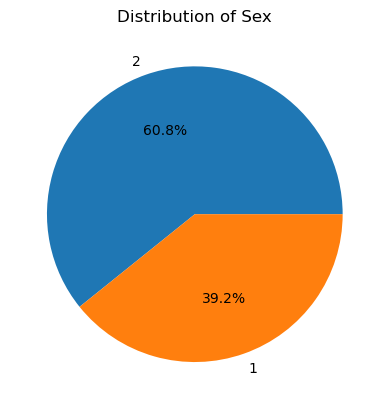

In [5]:
# Hitung jumlah data berdasarkan jenis kelamin
sex_counts = df['sex'].value_counts()

# Plot pie chart
fig, ax = plt.subplots()
ax.pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%')
ax.set_title('Distribution of Sex')

In [13]:
show_data(df,'education_level')

counts  presentase %
education_level                      
2                  1400         47.23
1                  1038         35.02
3                   483         16.30
5                    24          0.81
4                    13          0.44
6                     4          0.13
0                     2          0.07

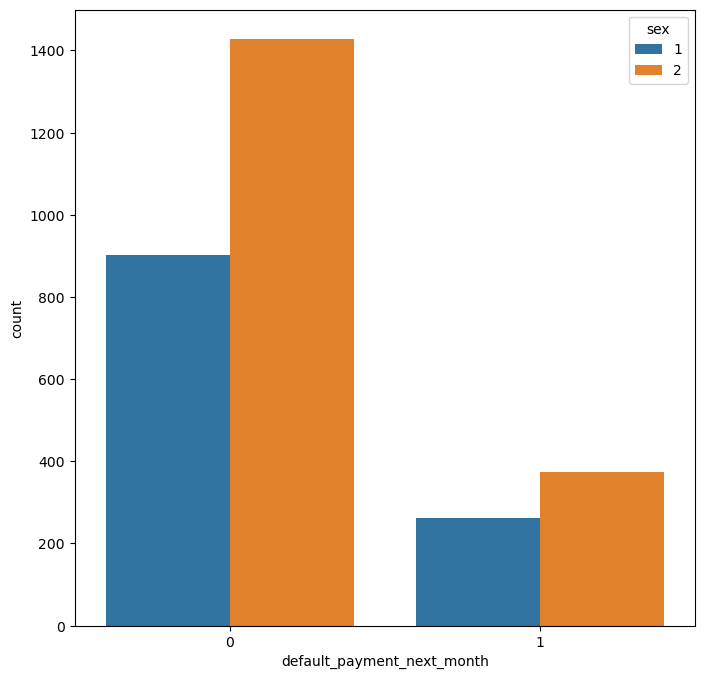

In [14]:
#Pembagian Sex berdasarkan default_payment_next_month
plt.figure(figsize=(8,8))
sns.countplot(x='default_payment_next_month',hue='sex', data=df)
plt.show()

Statement : perbandingan Sex Female dan Male terhadap default_payment_next_month

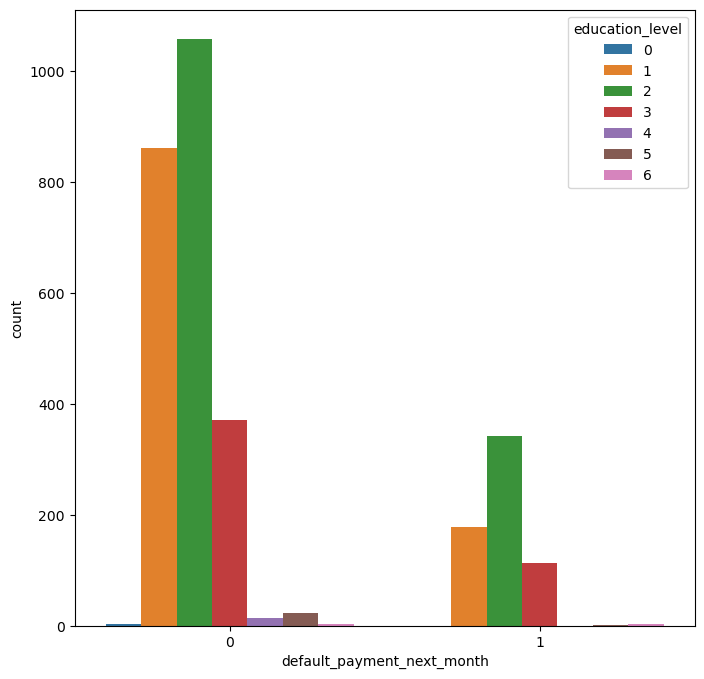

In [15]:
#Pembagian education berdasarkan default_payment_next_month
plt.figure(figsize=(8,8))
sns.countplot(x='default_payment_next_month',hue='education_level', data=df)
plt.show()

tipe education_level 2 (university) menjadi yang terbanyak dalam default_payment_next_month berkatagori (0)

In [16]:
#fungsi untuk melihat distribusi data
def visual_data(df, a, b, c, d, z):
    fig, axes = plt.subplots(1,2, figsize=(12,8))
    sns.histplot(ax = axes[0], data = df[a], kde=True, bins=30)
    axes[0].set_title('Histogram of ' + a)
    axes[0].lines[0].set_color('crimson')
    sns.regplot(ax = axes[1], x = z, y = a, data = df, line_kws = {'color' : 'red'})
    axes[1].set_title(z + ' Vs ' + a)
    
    fig, axes = plt.subplots(1,2, figsize=(12,8))
    sns.histplot(ax = axes[0], data = df[b], kde=True, bins=30)
    axes[0].set_title('Histogram of ' + b)
    axes[0].lines[0].set_color('crimson')
    sns.regplot(ax = axes[1], x = z, y = b, data = df, line_kws = {'color' : 'red'})
    axes[1].set_title(z + ' Vs ' + b)
    
    fig, axes = plt.subplots(1,2, figsize=(12,8))
    sns.histplot(ax = axes[0], data = df[c], kde=True, bins=30)
    axes[0].set_title('Histogram of ' + c)
    axes[0].lines[0].set_color('crimson')
    sns.regplot(ax = axes[1], x = z, y = c, data = df, line_kws = {'color' : 'red'})
    axes[1].set_title(z + ' Vs ' + c) 

    fig, axes = plt.subplots(1,2, figsize=(12,8))
    sns.histplot(ax = axes[0], data = df[d], kde=True, bins=30)
    axes[0].set_title('Histogram of ' + d)
    axes[0].lines[0].set_color('crimson')
    sns.regplot(ax = axes[1], x = z, y = d, data = df, line_kws = {'color' : 'red'})
    axes[1].set_title(z + ' Vs ' + d)

    plt.show()

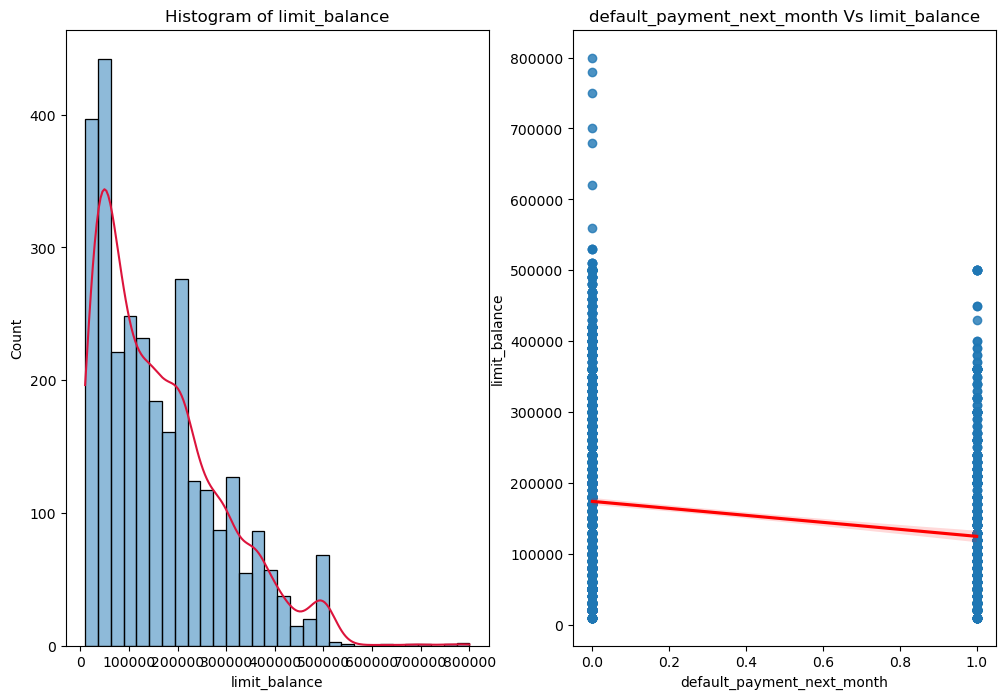

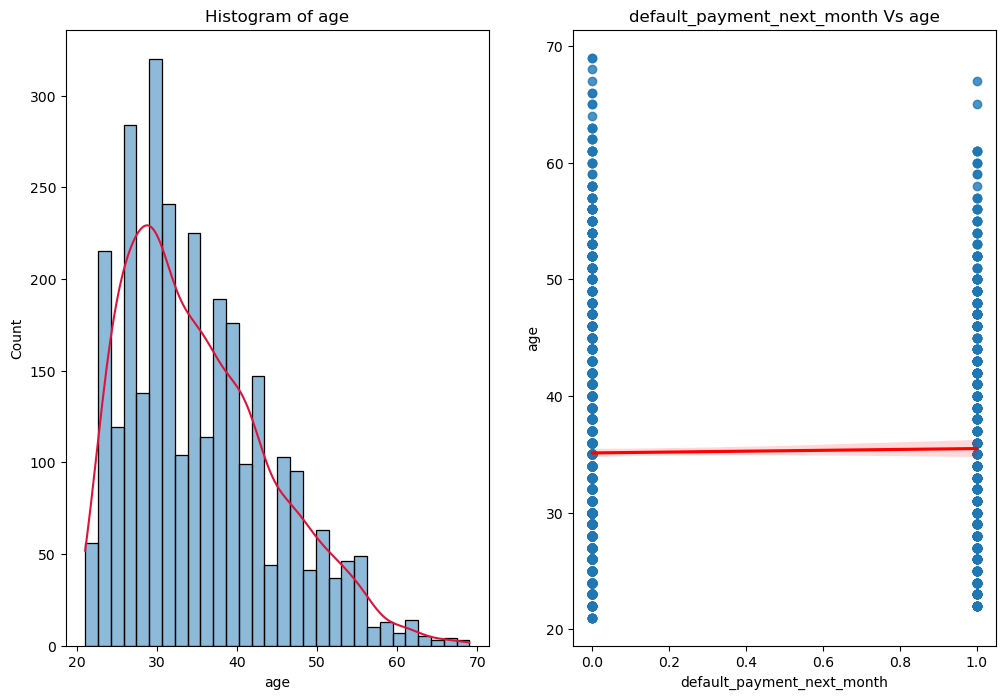

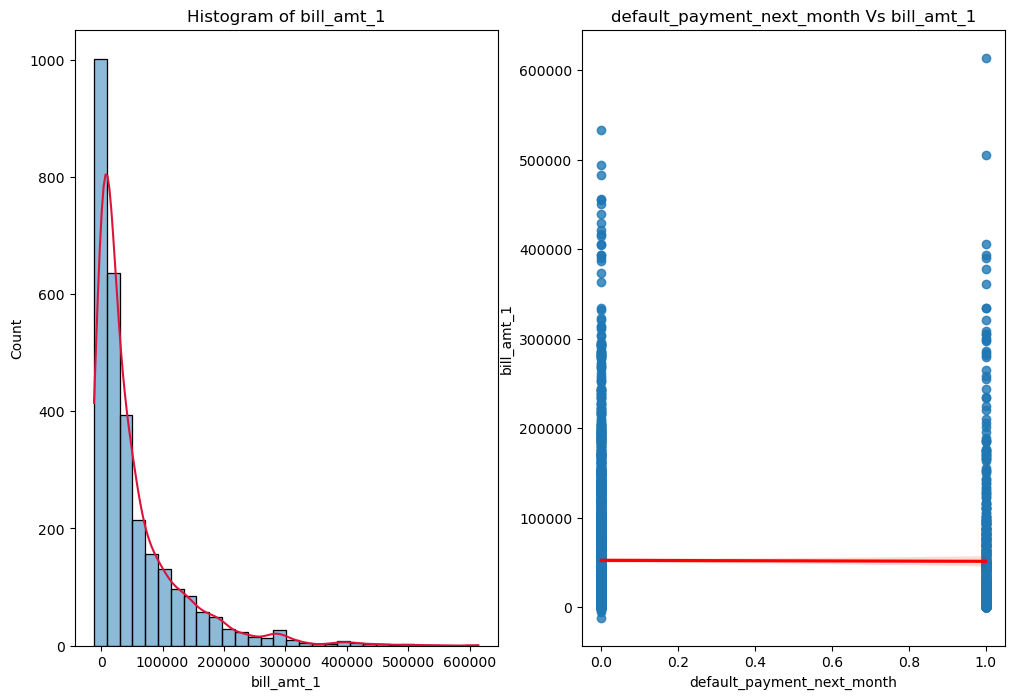

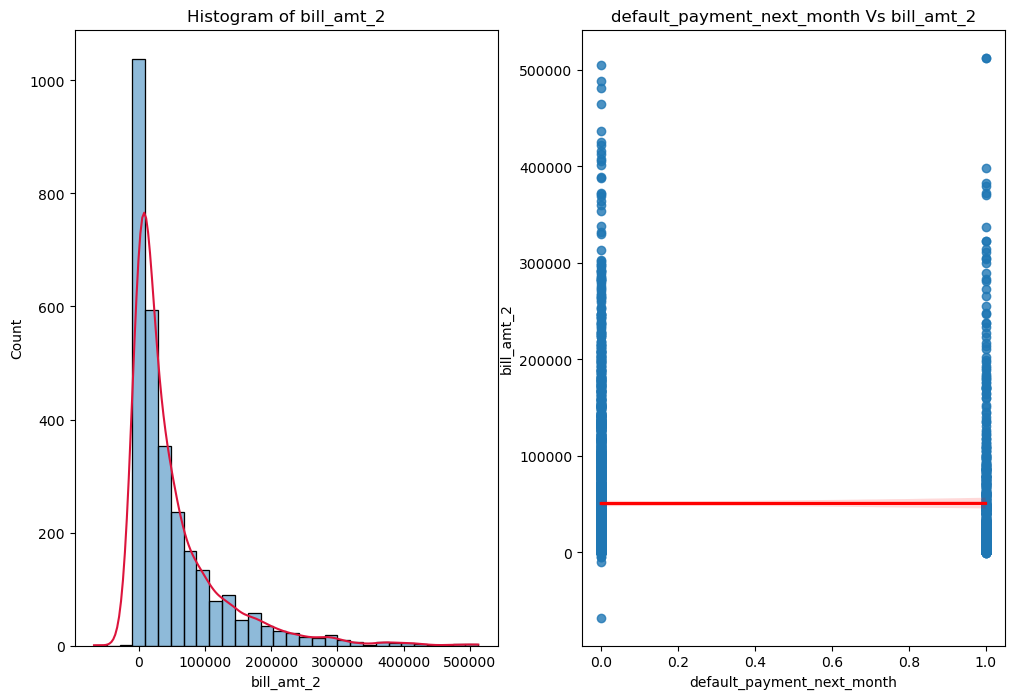

In [17]:
visual_data(df, 'limit_balance' , 'age' , 'bill_amt_1' , 'bill_amt_2' , 'default_payment_next_month')

# 6. Feature Engineering

## Data Cleaning

In [18]:
df_new=df.copy()

Karena tidak ada missing value pada data jadi kita tidak perlu handling missing value

## Split X (Feature) dan y (Target)

In [19]:
# spliting X dan y
X = df_new.drop(['default_payment_next_month'], axis=1)
y = df_new['default_payment_next_month']
X.shape

(2964, 23)

## Split train and test 

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print('Train Size : ', X_train.shape)
print('Test Size  : ', X_test.shape)
X_train

Train Size :  (2371, 23)
Test Size  :  (593, 23)


limit_balance  sex  education_level  marital_status   age  pay_0  pay_2  \
489        130000.0    1                2               2  27.0    0.0    0.0   
1743       240000.0    2                2               1  53.0    0.0    0.0   
835        210000.0    2                2               2  41.0    0.0    0.0   
1985        80000.0    2                1               1  25.0    3.0    2.0   
1246        50000.0    2                3               2  26.0    0.0    0.0   
...             ...  ...              ...             ...   ...    ...    ...   
153        170000.0    2                1               2  26.0    0.0    0.0   
93          70000.0    1                1               2  31.0    0.0    0.0   
2052        20000.0    1                2               2  23.0    0.0    0.0   
2677       250000.0    2                3               2  47.0   -2.0   -2.0   
357        100000.0    2                1               2  28.0    2.0    0.0   

      pay_3  pay_4  pay_5  pay_6  bill_amt_1  bill_amt_2  bill_amt_3  \
489     0.0    0.0    0.0    0.0    116646.0    113851.0    110317.0   
1743    0.0    0.0    2.0    0.0    135322.0    100522.0     84626.0   
835     0.0    0.0    0.0    0.0    227271.0    211597.0     99865.0   
1985    2.0    2.0    3.0    3.0      6269.0      7212.0      7246.0   
1246    0.0    0.0    0.0    0.0     35988.0     26708.0     25230.0   
...     ...    ...    ...    ...         ...         ...         ...   
153     0.0    0.0    0.0    0.0     22138.0     23227.0     18894.0   
93      0.0    0.0    0.0    0.0     47873.0     52440.0     55961.0   
2052    0.0   -1.0   -1.0    2.0     17821.0     19099.0         0.0   
2677   -2.0   -2.0   -2.0   -2.0      7363.0     27415.0         0.0   
357     0.0    0.0    0.0    0.0     96193.0     82342.0     81967.0   

      bill_amt_4  bill_amt_5  bill_amt_6  pay_amt_1  pay_amt_2  pay_amt_3  \
489     108099.0    106028.0    104253.0     5578.0     4000.0     3863.0   
1743     76205.0     46771.0     35207.0     4531.0     3728.0     3612.0   
835      77754.0     49529.0     30683.0     9000.0     4000.0     3018.0   
1985      8073.0      8349.0      8420.0     1200.0      300.0     1100.0   
1246     26999.0     27748.0     28351.0     1700.0     2000.0     3000.0   
...          ...         ...         ...        ...        ...        ...   
153       7695.0      4777.0      3517.0     1808.0     1054.0      207.0   
93       63341.0     64694.0     67905.0     6000.0     5000.0    10000.0   
2052      1728.0      1953.0      1780.0     2000.0        0.0     1728.0   
2677      1930.0      1643.0      1687.0    27474.0        0.0     1930.0   
357      82177.0     78840.0     79261.0     3600.0     3800.0     3000.0   

      pay_amt_4  pay_amt_5  pay_amt_6  
489      3831.0     4136.0     5385.0  
1743        0.0     1100.0     2000.0  
835      2000.0     3000.0     3000.0  
1985      700.0      500.0        0.0  
1246     1500.0     1200.0     1136.0  
...         ...        ...        ...  
153       151.0      147.0      100.0  
93       3000.0     5000.0     3000.0  
2052      225.0        0.0        0.0  
2677     1643.0     1687.0        0.0  
357      3000.0     3023.0     3000.0  

[2371 rows x 23 columns]

## Handling Cardinality

In [22]:
# Handling cardinality
X_train = X_train.replace({'education_level' : {1 : 1, 2 : 2, 3 : 3, 4 : 4, 5 : 4, 6 : 4, 0 :4}, 
                           'marital_status' : {1 : 1, 2 : 2, 3 : 3, 0 : 3}})
X_train['pay_0'] = X_train['pay_0'].replace([-1, -2], [0, 0])
X_train['pay_2'] = X_train['pay_2'].replace([-1, -2], [0, 0])
X_train['pay_3'] = X_train['pay_3'].replace([-1, -2], [0, 0])
X_train['pay_4'] = X_train['pay_4'].replace([-1, -2], [0, 0])
X_train['pay_5'] = X_train['pay_5'].replace([-1, -2], [0, 0])
X_train['pay_6'] = X_train['pay_6'].replace([-1, -2], [0, 0])
X_test = X_test.replace({'education_level' : {1 : 1, 2 : 2, 3 : 3, 4 : 4, 5 : 4, 6 : 4, 0 :4}, 
                           'marital_status' : {1 : 1, 2 : 2, 3 : 3, 0 : 3}})

X_test['pay_0'] = X_test['pay_0'].replace([-1, -2], [0, 0])
X_test['pay_2'] = X_test['pay_2'].replace([-1, -2], [0, 0])
X_test['pay_3'] = X_test['pay_3'].replace([-1, -2], [0, 0])
X_test['pay_4'] = X_test['pay_4'].replace([-1, -2], [0, 0])
X_test['pay_5'] = X_test['pay_5'].replace([-1, -2], [0, 0])
X_test['pay_6'] = X_test['pay_6'].replace([-1, -2], [0, 0])

In [23]:
# Membuat Function Untuk Menampilkan Grafik Histogram dan Boxplot
def diagnostic_plots(df, variable1, variable2, variable3, variable4):
    plt.figure(figsize=(18, 4))
    
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable1], bins=20)
    plt.title('Histogram of ' + variable1)
    
    plt.subplot(1, 2, 2)
    sns.boxplot(df[variable1])
    plt.title('Boxplot of ' + variable1)
    
    print('Skewness Value of', variable1,':', df[variable1].skew() )
    
    plt.figure(figsize=(18, 4))
    
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable2], bins=20)
    plt.title('Histogram of ' + variable2)
    
    plt.subplot(1, 2, 2)
    sns.boxplot(df[variable2])
    plt.title('Boxplot of ' + variable2)
    
    print('Skewness Value of', variable2,':', df[variable2].skew() )
    
    plt.figure(figsize=(18, 4))
    
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable3], bins=20)
    plt.title('Histogram of ' + variable3)
    
    plt.subplot(1, 2, 2)
    sns.boxplot(df[variable3])
    plt.title('Boxplot of ' + variable3)

    print('Skewness Value of', variable3,':', df[variable3].skew() )

    plt.figure(figsize=(18, 4))
    
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable4], bins=20)
    plt.title('Histogram of ' + variable4)
    
    plt.subplot(1, 2, 2)
    sns.boxplot(df[variable4])
    plt.title('Boxplot of ' + variable4)    
    
    print('Skewness Value of', variable4,':', df[variable4].skew() )

    plt.figure(figsize=(18, 4))
    
    plt.show()

Skewness Value of limit_balance : 1.015154459834294
Skewness Value of age : 0.7797800753654462
Skewness Value of bill_amt_1 : 2.349189799576379
Skewness Value of bill_amt_2 : 2.369960970634886


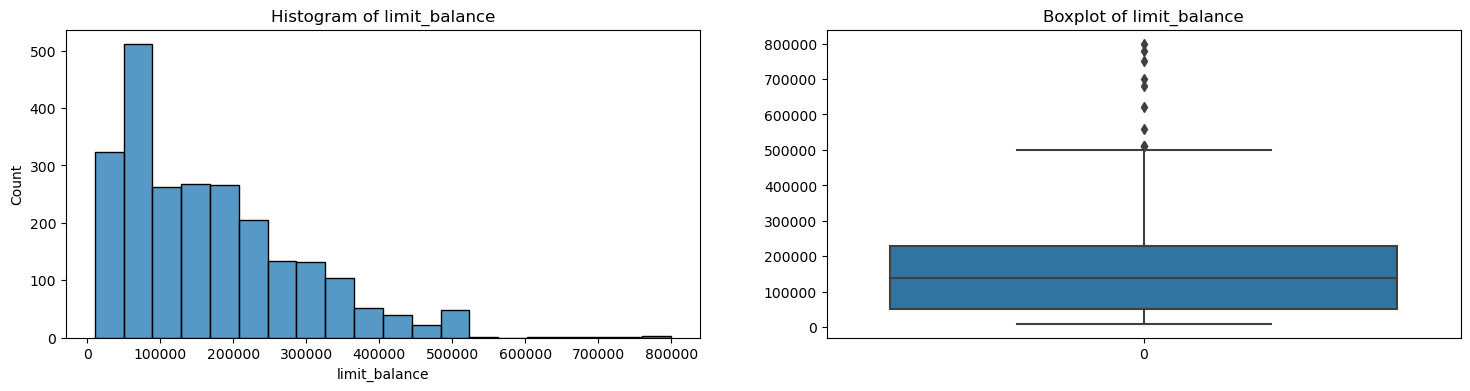

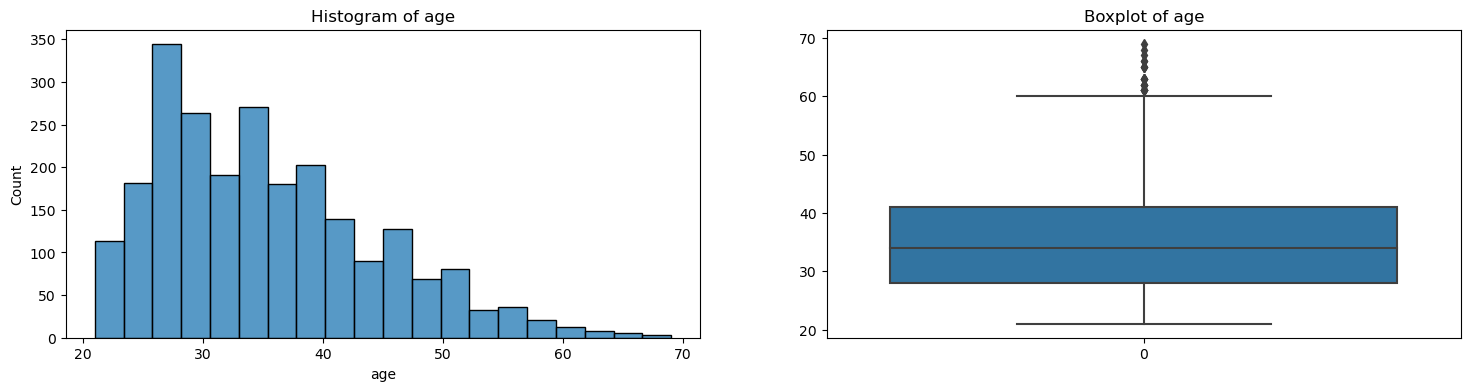

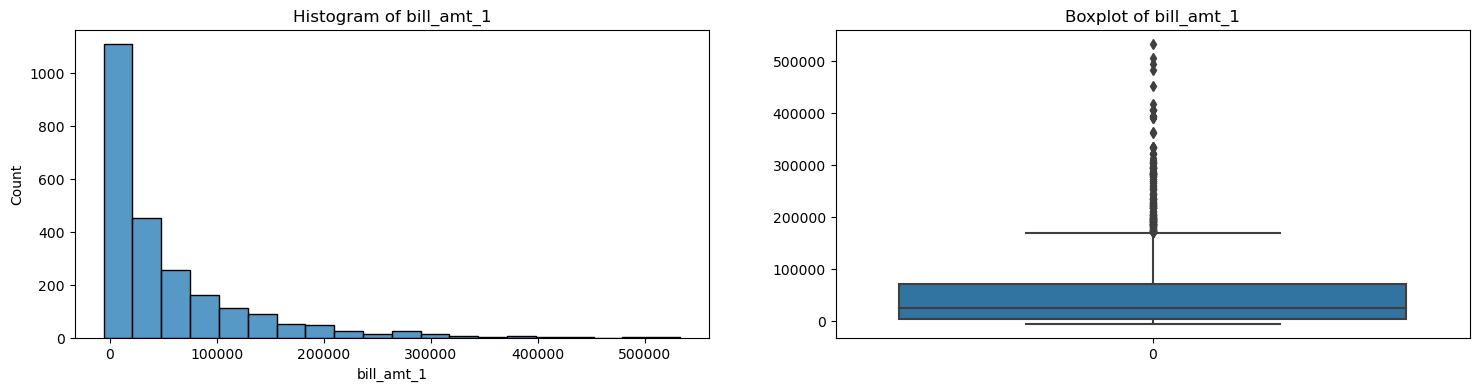

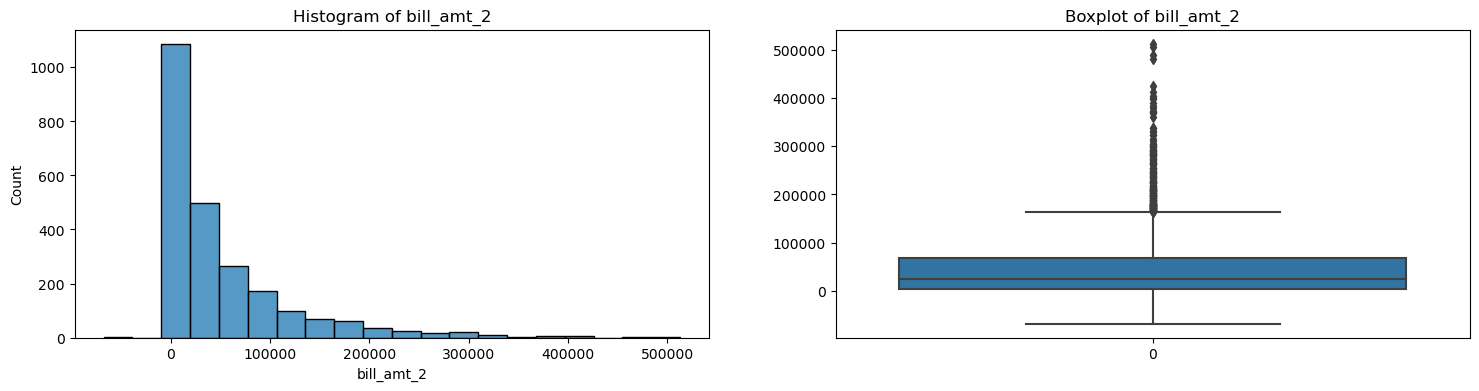

<Figure size 1800x400 with 0 Axes>

In [24]:
diagnostic_plots(X_train, 'limit_balance' ,'age' , 'bill_amt_1','bill_amt_2')

Skewness Value of bill_amt_5 : 2.352923236448307
Skewness Value of bill_amt_6 : 2.3518155875020557
Skewness Value of pay_amt_1 : 11.655794300460066
Skewness Value of pay_amt_2 : 27.71575393842848


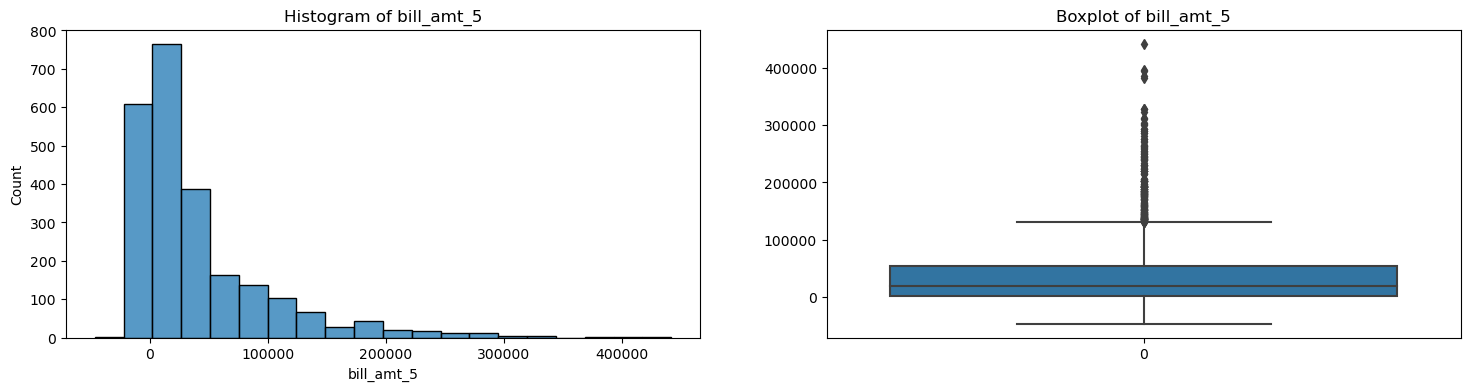

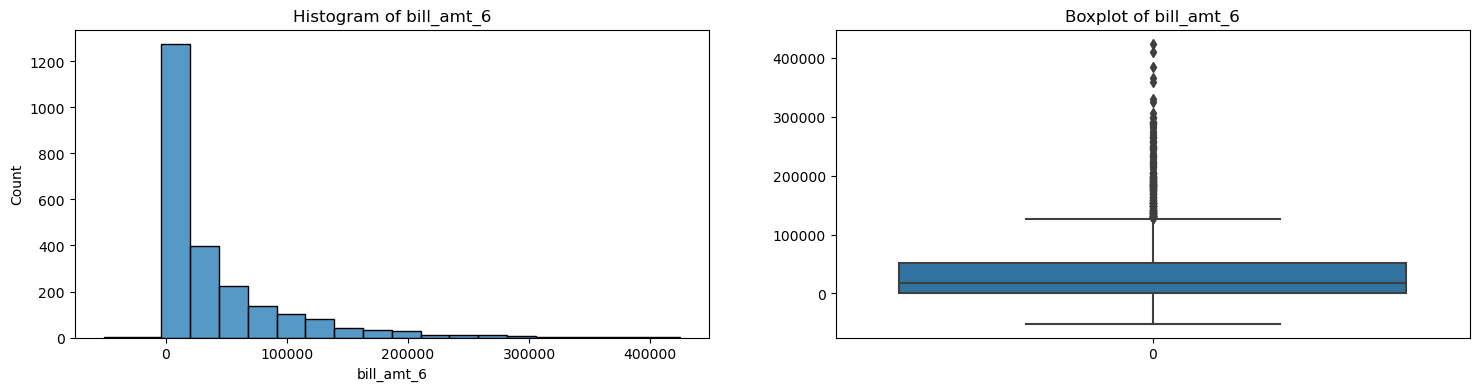

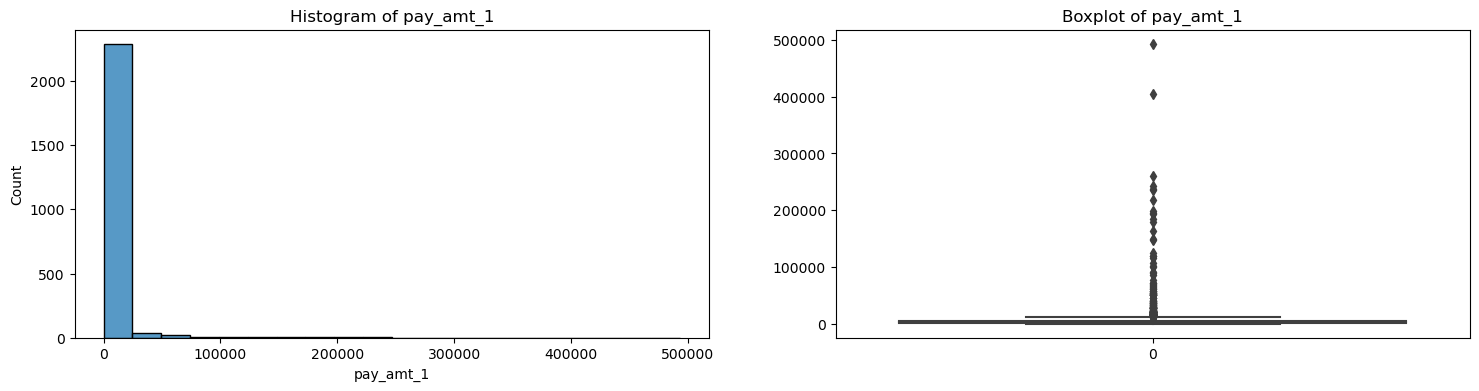

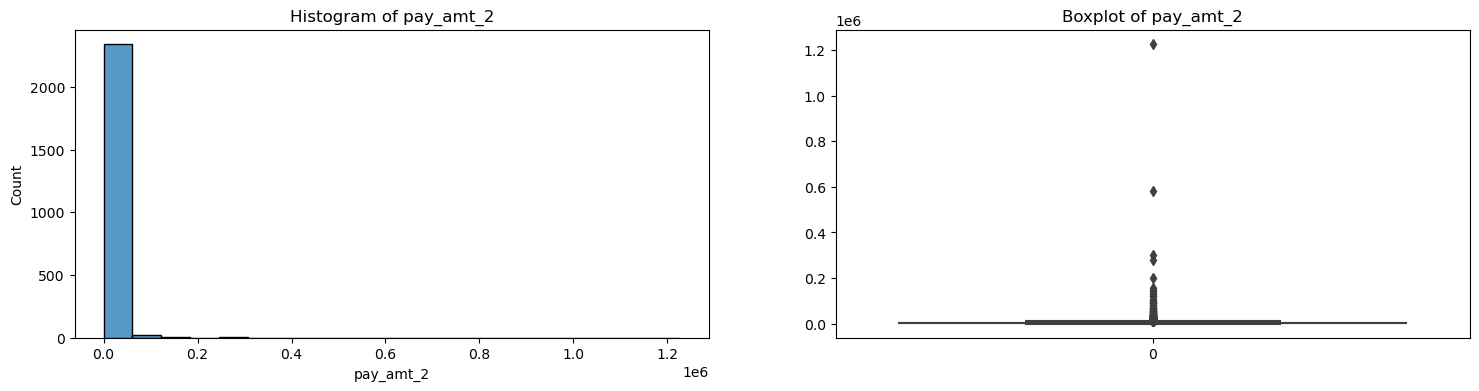

<Figure size 1800x400 with 0 Axes>

In [25]:
diagnostic_plots(X_train,'bill_amt_5','bill_amt_6','pay_amt_1','pay_amt_2')

Skewness Value of pay_amt_3 : 8.123260617950287
Skewness Value of pay_amt_4 : 9.16420241803223
Skewness Value of pay_amt_5 : 10.984708402762779
Skewness Value of pay_amt_6 : 10.046608445599082


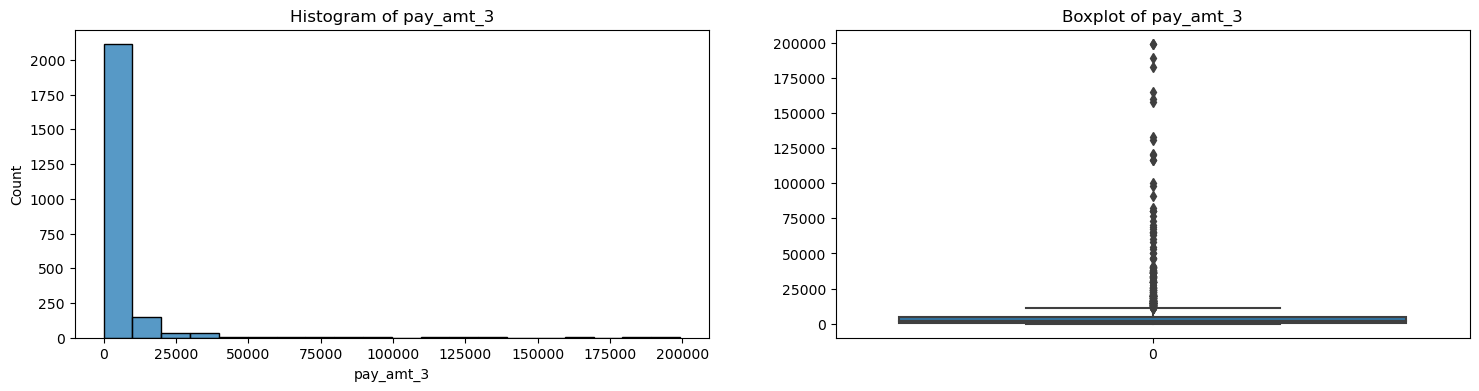

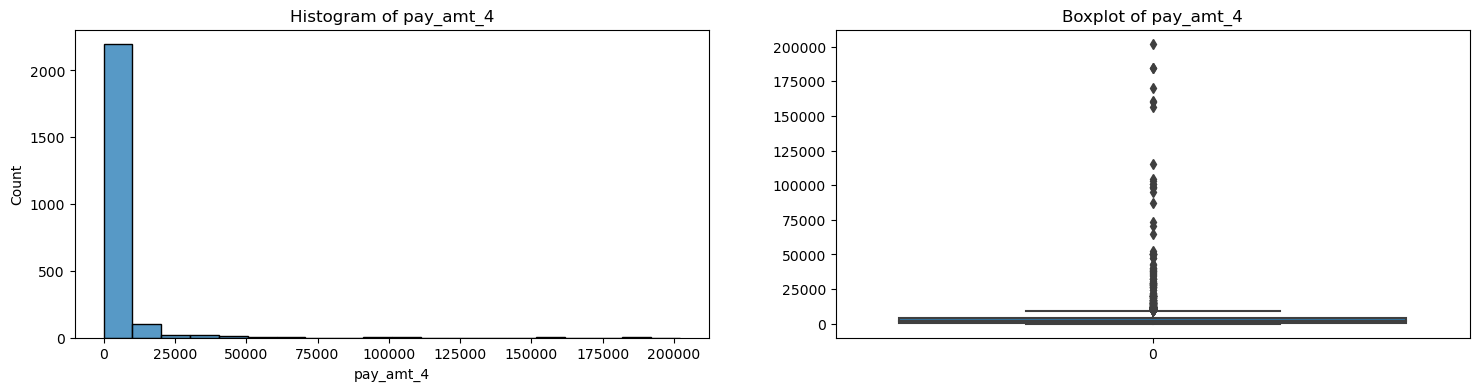

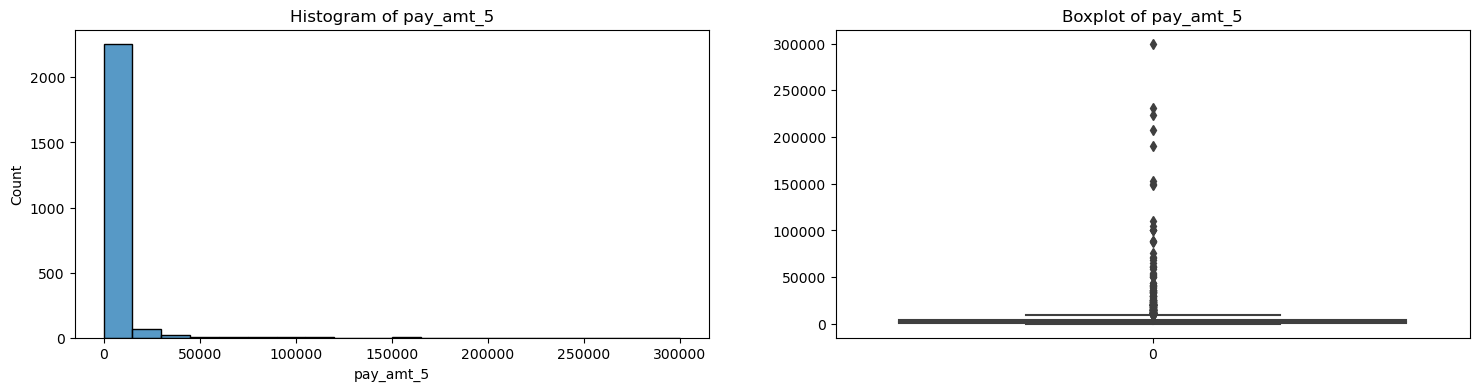

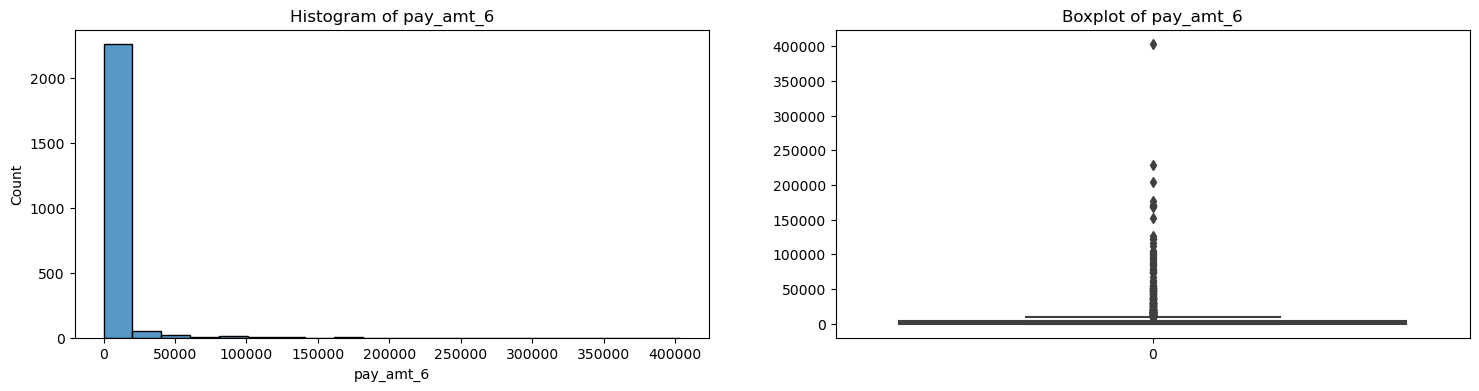

<Figure size 1800x400 with 0 Axes>

In [26]:
diagnostic_plots(X_train, 'pay_amt_3' ,'pay_amt_4' ,'pay_amt_5' ,'pay_amt_6')

Statement : dari semua distribusi data dapat disimpulkan bawah distribusi data `tidak normal`

In [32]:
winsoriser= Winsorizer(capping_method='iqr',
             tail='both',
             fold=1.5,
             variables=['limit_balance','age',	
                        'bill_amt_1','bill_amt_2', 'bill_amt_3'	,'bill_amt_4'	,'bill_amt_5'	,
                        'bill_amt_6','pay_amt_1','pay_amt_2','pay_amt_3','pay_amt_4','pay_amt_5','pay_amt_6'])
winsoriser.fit(X_train)
X_train_t = winsoriser.transform(X_train)

## Missing value

In [33]:
#cek missing value
X_train.isnull().sum()

limit_balance      0
sex                0
education_level    0
marital_status     0
age                0
pay_0              0
pay_2              0
pay_3              0
pay_4              0
pay_5              0
pay_6              0
bill_amt_1         0
bill_amt_2         0
bill_amt_3         0
bill_amt_4         0
bill_amt_5         0
bill_amt_6         0
pay_amt_1          0
pay_amt_2          0
pay_amt_3          0
pay_amt_4          0
pay_amt_5          0
pay_amt_6          0
dtype: int64

In [34]:
# cek missing value
X_test.isnull().sum()

limit_balance      0
sex                0
education_level    0
marital_status     0
age                0
pay_0              0
pay_2              0
pay_3              0
pay_4              0
pay_5              0
pay_6              0
bill_amt_1         0
bill_amt_2         0
bill_amt_3         0
bill_amt_4         0
bill_amt_5         0
bill_amt_6         0
pay_amt_1          0
pay_amt_2          0
pay_amt_3          0
pay_amt_4          0
pay_amt_5          0
pay_amt_6          0
dtype: int64

In [35]:
# missing value bukan null
show_data(X_train, 'education_level')

counts  presentase %
education_level                      
2                  1093         46.10
1                   852         35.93
3                   390         16.45
4                    36          1.52

In [36]:
#missing value bukan null
show_data(X_train, 'marital_status')

counts  presentase %
marital_status                      
2                 1269         53.52
1                 1071         45.17
3                   31          1.31

* Handling missing value pada feature tidak dilakukan karena tidak ada nya nilai null didalam data . Sementara ada nilai **Unknown** didalam data `education_level` dan `marital_status`
* Karena data `education_level` dan `marital_status` memiliki hubungan dengan data lain maka dikatakan bahwa jenis missing value pada data tersebut adalah `Missing Not at Random` **(MNAR)**


## Scaling

karena distribusi data tidak normal, maka scaling menggunakan `MinMaxScaler`

In [37]:
#split kolom yang ingin di scale
num_cols_non_scaled=['sex' ,'education_level', 'marital_status' ,'pay_0' ,'pay_2','pay_3','pay_4','pay_5', 'pay_6' ]
num_cols_scaled=X.drop(num_cols_non_scaled, axis=1).columns.tolist()

In [38]:
#split data 
X_train_sc=X_train[num_cols_scaled]
X_test_sc=X_test[num_cols_scaled]

X_train_non_scale=X_train[num_cols_non_scaled]
X_test_non_scaled=X_test[num_cols_non_scaled]

In [39]:
#define MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train_sc)

X_train_num_scaled=scaler.transform(X_train_sc)
X_test_num_scaled=scaler.transform(X_test_sc)

In [40]:
#menjadikan hasil scaling menjadi dataframe
X_train_num_scaled=pd.DataFrame(X_train_num_scaled, columns=num_cols_scaled)
X_train_num_scaled

limit_balance       age  bill_amt_1  bill_amt_2  bill_amt_3  bill_amt_4  \
0          0.151899  0.125000    0.227031    0.312624    0.232007    0.290906   
1          0.291139  0.666667    0.261691    0.289650    0.188102    0.230941   
2          0.253165  0.416667    0.432338    0.481101    0.214145    0.233853   
3          0.088608  0.083333    0.022183    0.128820    0.055864    0.102844   
4          0.050633  0.104167    0.077339    0.162423    0.086598    0.138427   
...             ...       ...         ...         ...         ...         ...   
2366       0.202532  0.104167    0.051634    0.156423    0.075770    0.102133   
2367       0.075949  0.208333    0.099396    0.206775    0.139115    0.206755   
2368       0.012658  0.041667    0.043623    0.149308    0.043481    0.090914   
2369       0.303797  0.541667    0.024214    0.163642    0.043481    0.091294   
2370       0.113924  0.145833    0.189072    0.258315    0.183558    0.242169   

      bill_amt_5  bill_amt_6  pay_amt_1  pay_amt_2  pay_amt_3  pay_amt_4  \
0       0.312428    0.326701   0.011306   0.003260   0.019392   0.018958   
1       0.191151    0.181577   0.009184   0.003038   0.018132   0.000000   
2       0.196796    0.172069   0.018242   0.003260   0.015150   0.009897   
3       0.112516    0.125276   0.002432   0.000244   0.005522   0.003464   
4       0.152218    0.167167   0.003446   0.001630   0.015060   0.007423   
...          ...         ...        ...        ...        ...        ...   
2366    0.105205    0.114970   0.003665   0.000859   0.001039   0.000747   
2367    0.227833    0.250303   0.012162   0.004075   0.050199   0.014846   
2368    0.099425    0.111319   0.004054   0.000000   0.008674   0.001113   
2369    0.098791    0.111124   0.055688   0.000000   0.009688   0.008131   
2370    0.256785    0.274172   0.007297   0.003097   0.015060   0.014846   

      pay_amt_5  pay_amt_6  
0      0.013787   0.013346  
1      0.003667   0.004957  
2      0.010000   0.007435  
3      0.001667   0.000000  
4      0.004000   0.002815  
...         ...        ...  
2366   0.000490   0.000248  
2367   0.016667   0.007435  
2368   0.000000   0.000000  
2369   0.005623   0.000000  
2370   0.010077   0.007435  

[2371 rows x 14 columns]

In [41]:
#menjadikan hasil scaling menjadi data frame
X_test_num_scaled=pd.DataFrame(X_test_num_scaled, columns=num_cols_scaled)
X_test_num_scaled

limit_balance       age  bill_amt_1  bill_amt_2  bill_amt_3  bill_amt_4  \
0         0.037975  0.729167    0.010549    0.116389    0.043481    0.087665   
1         0.050633  0.062500    0.077121    0.178977    0.104707    0.149398   
2         0.063291  0.791667    0.120369    0.221395    0.149094    0.087665   
3         0.012658  0.083333    0.043862    0.146259    0.075199    0.114944   
4         0.164557  0.333333    0.261342    0.356278    0.282563    0.293850   
..             ...       ...         ...         ...         ...         ...   
588       0.443038  0.187500    0.025758    0.288743    0.044839    0.089545   
589       0.012658  0.041667    0.016647    0.127318    0.053900    0.099583   
590       0.075949  0.437500    0.022592    0.132543    0.062585    0.104000   
591       0.101266  0.083333    0.167761    0.266919    0.193632    0.123179   
592       0.050633  0.083333    0.093397    0.195277    0.124480    0.163519   

     bill_amt_5  bill_amt_6  pay_amt_1  pay_amt_2  pay_amt_3  pay_amt_4  \
0      0.095428    0.107578   0.000000   0.000000   0.000000   0.000000   
1      0.154887    0.167035   0.010135   0.004075   0.028693   0.014846   
2      0.200422    0.217561   0.006685   0.002445   0.000000   0.253870   
3      0.132210    0.139846   0.004054   0.001630   0.005020   0.029692   
4      0.316728    0.334717   0.013586   0.004987   0.020155   0.020002   
..          ...         ...        ...        ...        ...        ...   
588    0.108523    0.127373   0.203698   0.000651   0.005045   0.031661   
589    0.105954    0.118352   0.006689   0.000000   0.002565   0.001485   
590    0.112405    0.128905   0.006081   0.001630   0.001481   0.004949   
591    0.093826    0.262206   0.008108   0.002655   0.005020   0.000000   
592    0.158880    0.169988   0.003790   0.002037   0.015145   0.005246   

     pay_amt_5  pay_amt_6  
0     0.000000   0.000000  
1     0.006667   0.003717  
2     0.006763   0.005162  
3     0.003333   0.007435  
4     0.013523   0.009943  
..         ...        ...  
588   0.010067   0.007534  
589   0.001000   0.003717  
590   0.006667   0.002478  
591   0.258333   0.000000  
592   0.004333   0.004957  

[593 rows x 14 columns]

In [42]:
# index reset
X_train_num_scaled.reset_index(drop=True, inplace=True)
X_train_non_scale.reset_index(drop=True, inplace=True)

X_test_num_scaled.reset_index(drop=True, inplace=True)
X_test_non_scaled.reset_index(drop=True, inplace=True)

In [43]:
#Concat data scale dan non scale
X_train_con = pd.concat([X_train_num_scaled,X_train_non_scale] , axis=1)
X_test_con = pd.concat([X_test_num_scaled,X_test_non_scaled] ,  axis=1)

In [44]:
X_train_con.head(3)

limit_balance       age  bill_amt_1  bill_amt_2  bill_amt_3  bill_amt_4  \
0       0.151899  0.125000    0.227031    0.312624    0.232007    0.290906   
1       0.291139  0.666667    0.261691    0.289650    0.188102    0.230941   
2       0.253165  0.416667    0.432338    0.481101    0.214145    0.233853   

   bill_amt_5  bill_amt_6  pay_amt_1  pay_amt_2  pay_amt_3  pay_amt_4  \
0    0.312428    0.326701   0.011306   0.003260   0.019392   0.018958   
1    0.191151    0.181577   0.009184   0.003038   0.018132   0.000000   
2    0.196796    0.172069   0.018242   0.003260   0.015150   0.009897   

   pay_amt_5  pay_amt_6  sex  education_level  marital_status  pay_0  pay_2  \
0   0.013787   0.013346    1                2               2    0.0    0.0   
1   0.003667   0.004957    2                2               1    0.0    0.0   
2   0.010000   0.007435    2                2               2    0.0    0.0   

   pay_3  pay_4  pay_5  pay_6  
0    0.0    0.0    0.0    0.0  
1    0.0    0.0    2.0    0.0  
2    0.0    0.0    0.0    0.0

## Feature Encoding

Encoding tidak dilakukan karena data kategorikal sudah berbentuk number

## Feature Selection

### checking corelation

#### Pearson

In [45]:
# Pearson

Xy_train = pd.concat([X_train_con, y_train], axis=1)
Xy_corr = Xy_train.corr().default_payment_next_month.sort_values(ascending= False)

In [46]:
#menampilkan data korelasi teratas dari 0
print(Xy_corr)

default_payment_next_month    1.000000
pay_5                         0.032551
pay_amt_3                     0.031802
pay_amt_4                     0.030867
pay_0                         0.022200
limit_balance                 0.019469
sex                           0.017422
pay_2                         0.016172
pay_6                         0.015477
pay_3                         0.013626
marital_status                0.002779
pay_4                         0.002730
age                          -0.007186
education_level              -0.008329
pay_amt_2                    -0.016662
pay_amt_6                    -0.021414
pay_amt_1                    -0.023916
bill_amt_1                   -0.024308
bill_amt_4                   -0.025485
bill_amt_5                   -0.025985
bill_amt_6                   -0.026466
bill_amt_3                   -0.029819
bill_amt_2                   -0.030379
pay_amt_5                    -0.034273
Name: default_payment_next_month, dtype: float64


#### Multicoreniality

In [47]:
# FUngsi menghitung nilai VIF
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X_train_con.columns
    vif["VIF"] = [variance_inflation_factor(X_train_con.values, i) for i in range(X_train_con.shape[1])]
    vif = vif.sort_values(by=['VIF'],ascending=False)
    return(vif)

In [48]:
calc_vif(X_train_con)

variables        VIF
6        bill_amt_5  72.545931
3        bill_amt_2  72.121775
5        bill_amt_4  67.461782
7        bill_amt_6  45.737452
4        bill_amt_3  40.531919
2        bill_amt_1  19.205975
14              sex   9.443407
16   marital_status   8.101062
15  education_level   6.935514
1               age   3.832413
21            pay_5   3.789698
0     limit_balance   3.393473
20            pay_4   3.241940
18            pay_2   3.173483
19            pay_3   2.780088
22            pay_6   2.688053
17            pay_0   2.545890
8         pay_amt_1   2.392156
9         pay_amt_2   1.919243
10        pay_amt_3   1.901277
11        pay_amt_4   1.588981
12        pay_amt_5   1.494747
13        pay_amt_6   1.224894

 Berdasarkan multicoreneality feature yang dapat digunakan adalah : 'age' , pay_5 , limit_balance , pay_4 , pay_2 , pay_3 , pay_6 pay_0 , pay_amt_1 , pay_amt_2 , pay_amt_3 , pay_amt_4 , pay_amt_5 , pay_amt_6

#### chhi2square

In [49]:
### chi2squre

chi_scores, p_values = [], []
for col in X_train_non_scale.columns:
    cont = pd.crosstab(X_train_non_scale[col], y)
    chi2, p, dof, ex = chi2_contingency(cont)
    chi_scores.append(chi2)
    p_values.append(p)

# create a DataFrame to show the results
results = pd.DataFrame({'feature': X_train_non_scale.columns, 'chi2_score': chi_scores, 'p_value': p_values})
print(results)

           feature  chi2_score   p_value
0              sex    0.000000  1.000000
1  education_level    1.339413  0.719796
2   marital_status    0.352374  0.838461
3            pay_0    4.502185  0.809214
4            pay_2    3.881336  0.793339
5            pay_3    7.760185  0.256205
6            pay_4    7.780398  0.352356
7            pay_5    3.175293  0.786546
8            pay_6    5.879357  0.318136


#### Feature

In [75]:
feature_train1= X_train_con.loc[:,['pay_0','pay_2','pay_3','pay_4','pay_5','pay_6','bill_amt_1','bill_amt_2','bill_amt_3','bill_amt_4','bill_amt_5','bill_amt_6',
                                   'pay_amt_1','pay_amt_2','pay_amt_3','pay_amt_4','pay_amt_5','pay_amt_6']]
feature_test1= X_test_con.loc[:,['pay_0','pay_2','pay_3','pay_4','pay_5','pay_6','bill_amt_1','bill_amt_2','bill_amt_3','bill_amt_4','bill_amt_5','bill_amt_6',
                                   'pay_amt_1','pay_amt_2','pay_amt_3','pay_amt_4','pay_amt_5','pay_amt_6']] 

In [76]:
feature_train = X_train_con
feature_test = X_test_con

# 7. Model Definition

In [177]:
# Logistic Regression
log_reg=LogisticRegression()

In [178]:
# SVM
svm = SVC()

In [179]:
# Decission Tree
dt = DecisionTreeClassifier()

In [180]:
# Random FOrest
random = RandomForestClassifier()

In [181]:
#KNN
knn=KNeighborsClassifier()

In [182]:
#Naive Bayes
nb=GaussianNB()

In [216]:
# Adabus
adaboost = AdaBoostClassifier()

# 8. Model Training

### LogisticRegression

In [183]:
#melatih model
log_reg.fit(feature_train1,y_train)

LogisticRegression()

In [184]:
log_reg.classes_

array([0, 1], dtype=int64)

In [185]:
# melakukan prediksi
y_pred_train_logreg = log_reg.predict(feature_train1)
y_pred_test_logreg = log_reg.predict(feature_test1)

Evaluation Logistic Regression
Training score: 0.8452
Test score: 0.8111 

Classification Report Train-set Logistic Regression :
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1863
           1       0.75      0.42      0.54       508

    accuracy                           0.85      2371
   macro avg       0.80      0.69      0.72      2371
weighted avg       0.83      0.85      0.83      2371
 

Confusion Matrix      : 


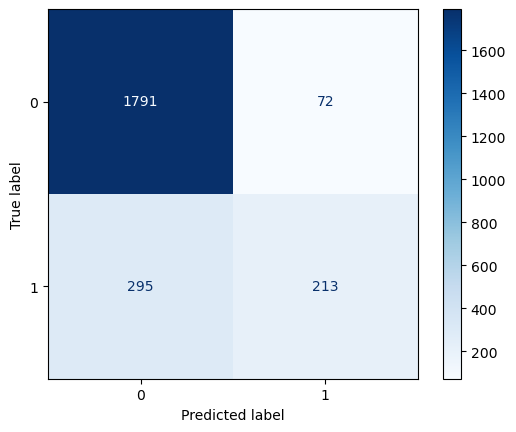

In [186]:
# Menampilkan akurasi prediksi
print("Evaluation Logistic Regression")
print('Training score: {:.4f}'.format(log_reg.score(feature_train1, y_train)))
print('Test score: {:.4f}'.format(log_reg.score(feature_test1, y_test)), '\n')
# Menampilkan classification report untuk data Train
print('Classification Report Train-set Logistic Regression :')
print(classification_report(y_train,y_pred_train_logreg), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(log_reg, feature_train1, y_train, cmap='Blues'))

#### Crosvalidation

In [187]:
# Cross validation
f1_cv_log = cross_val_score(log_reg, 
                                           feature_train1, 
                                           y_train, 
                                           cv=5, 
                                           scoring='f1')

print('F1 Score - All - Cross Validation  : ', f1_cv_log)
print('F1 Score - Mean - Cross Validation : ', f1_cv_log.mean())
print('F1 Score - Std - Cross Validation  : ', f1_cv_log.std())
print('F1 Score - Range of Test-Set       : ', (f1_cv_log.mean()-f1_cv_log.std()) , '-', (f1_cv_log.mean()+f1_cv_log.std()))

F1 Score - All - Cross Validation  :  [0.56626506 0.45637584 0.5        0.59756098 0.49673203]
F1 Score - Mean - Cross Validation :  0.5233867801841371
F1 Score - Std - Cross Validation  :  0.05116295889856292
F1 Score - Range of Test-Set       :  0.47222382128557416 - 0.5745497390827


F1 Score - Test Set   :  0.43434343434343436 

ROC-AUC Train:  0.6903219977937541 

ROC-AUC Test:  0.6392484201277416 

Classification Report Test-set Logistic Regression : 
               precision    recall  f1-score   support

           0       0.84      0.94      0.89       466
           1       0.61      0.34      0.43       127

    accuracy                           0.81       593
   macro avg       0.72      0.64      0.66       593
weighted avg       0.79      0.81      0.79       593
 

Confusion Matrix      : 


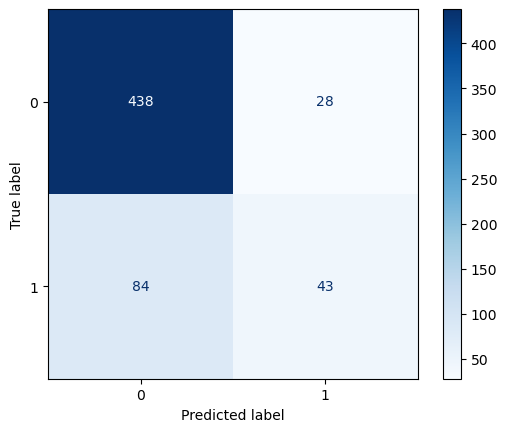

In [269]:
#Check setelah crosvalidation
y_pred_test_log = log_reg.predict(feature_test1)

print('F1 Score - Test Set   : ', f1_score(y_test, y_pred_test_log), '\n')
print('ROC-AUC Train: ', roc_auc_score(y_train, y_pred_train_logreg), '\n')
print('ROC-AUC Test: ', roc_auc_score(y_test, y_pred_test_log), '\n')
print('Classification Report Test-set Logistic Regression : \n', classification_report(y_test, y_pred_test_log), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(log_reg, feature_test1, y_test, cmap='Blues'))

### SVM

In [189]:
#melatih model SVM
svm.fit(feature_train1, y_train)

SVC()

In [190]:
#melakukan prediksi
y_pred_train_svm=svm.predict(feature_train1)
y_pred_test_svm=svm.predict(feature_test1)

Evaluation SVM
Training score: 0.8524
Test score: 0.8094 

Classification Report Train-set SVM :
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1863
           1       0.75      0.46      0.57       508

    accuracy                           0.85      2371
   macro avg       0.81      0.71      0.74      2371
weighted avg       0.84      0.85      0.84      2371
 

Confusion Matrix      : 


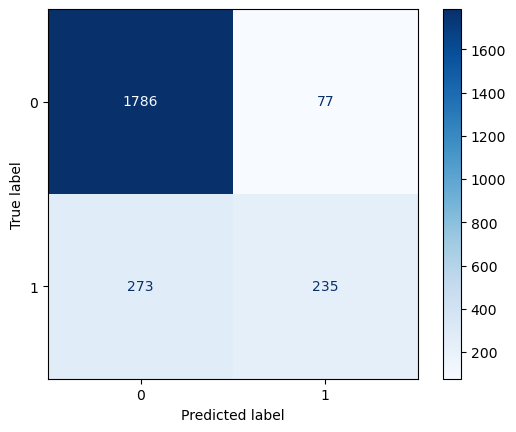

In [252]:
# Menampilkan akurasi prediksi
print("Evaluation SVM")
print('Training score: {:.4f}'.format(svm.score(feature_train1, y_train)))
print('Test score: {:.4f}'.format(svm.score(feature_test1, y_test)), '\n')
# Menampilkan classification report untuk data Train
print('Classification Report Train-set SVM :')
print(classification_report(y_train,y_pred_train_svm), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(svm, feature_train1, y_train, cmap='Blues'))

#### Crosvalidation

In [192]:
# Cross validation
f1_cv_svm = cross_val_score(svm, 
                                           feature_train1, 
                                           y_train, 
                                           cv=5, 
                                           scoring='f1')

print('F1 Score - All - Cross Validation  : ', f1_cv_svm)
print('F1 Score - Mean - Cross Validation : ', f1_cv_svm.mean())
print('F1 Score - Std - Cross Validation  : ', f1_cv_svm.std())
print('F1 Score - Range of Test-Set       : ', (f1_cv_svm.mean()-f1_cv_svm.std()) , '-', (f1_cv_svm.mean()+f1_cv_svm.std()))

F1 Score - All - Cross Validation  :  [0.56666667 0.50887574 0.5508982  0.61349693 0.52830189]
F1 Score - Mean - Cross Validation :  0.5536478858424483
F1 Score - Std - Cross Validation  :  0.03579363780687108
F1 Score - Range of Test-Set       :  0.5178542480355772 - 0.5894415236493193


F1 Score - Test Set   :  0.44878048780487806 

ROC-AUC Train:  0.710633619469064 

ROC-AUC Test :  0.6467675982562265 

Classification Report Test-set SVM : 
               precision    recall  f1-score   support

           0       0.84      0.93      0.88       466
           1       0.59      0.36      0.45       127

    accuracy                           0.81       593
   macro avg       0.72      0.65      0.67       593
weighted avg       0.79      0.81      0.79       593
 

Confusion Matrix      : 


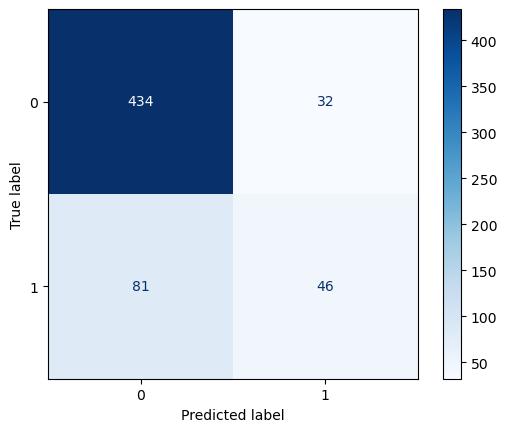

In [272]:
#Check setelah crosvalidation
y_pred_test_svm = svm.predict(feature_test1)

print('F1 Score - Test Set   : ', f1_score(y_test, y_pred_test_svm), '\n')
print('ROC-AUC Train: ', roc_auc_score(y_train, y_pred_train_svm), '\n')
print('ROC-AUC Test : ', roc_auc_score(y_test, y_pred_test_svm), '\n')
print('Classification Report Test-set SVM : \n', classification_report(y_test, y_pred_test_svm), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(svm, feature_test1, y_test, cmap='Blues'))

### DecisionTree

In [194]:
#melatih model DT
dt.fit(feature_train1, y_train)

DecisionTreeClassifier()

In [195]:
# melakukan prediksi
y_pred_train_dt = dt.predict(feature_train1)
y_pred_test_dt = dt.predict(feature_test1)

Evaluation DecisionTree
Training score: 0.9937
Test score: 0.7454 

Classification Report Train-set DecisionTree :
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1863
           1       1.00      0.97      0.99       508

    accuracy                           0.99      2371
   macro avg       1.00      0.99      0.99      2371
weighted avg       0.99      0.99      0.99      2371
 

Confusion Matrix      : 


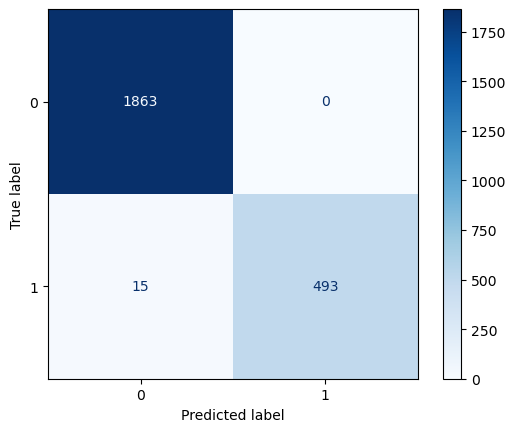

In [255]:
# Menampilkan akurasi prediksi
print("Evaluation DecisionTree")
print('Training score: {:.4f}'.format(dt.score(feature_train1, y_train)))
print('Test score: {:.4f}'.format(dt.score(feature_test1, y_test)), '\n')
# Menampilkan classification report untuk data Train
print('Classification Report Train-set DecisionTree :')
print(classification_report(y_train,y_pred_train_dt), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(dt, feature_train1, y_train, cmap='Blues'))

#### Crossvalidation

In [197]:
# Cross validation
f1_cv_dt = cross_val_score(dt, 
                                           feature_train1, 
                                           y_train, 
                                           cv=5, 
                                           scoring='f1')

print('F1 Score - All - Cross Validation  : ', f1_cv_dt)
print('F1 Score - Mean - Cross Validation : ', f1_cv_dt.mean())
print('F1 Score - Std - Cross Validation  : ', f1_cv_dt.std())
print('F1 Score - Range of Test-Set       : ', (f1_cv_dt.mean()-f1_cv_dt.std()) , '-', (f1_cv_dt.mean()+f1_cv_dt.std()))

F1 Score - All - Cross Validation  :  [0.38738739 0.37209302 0.45631068 0.43396226 0.37558685]
F1 Score - Mean - Cross Validation :  0.4050680417731778
F1 Score - Std - Cross Validation  :  0.033851977226094336
F1 Score - Range of Test-Set       :  0.37121606454708345 - 0.43892001899927213


F1 Score - Test Set   :  0.398406374501992 

ROC-AUC Train:  0.985236220472441 

ROC-AUC Test :  0.617451252069886 

Classification Report Test-set DecissionTree : 
               precision    recall  f1-score   support

           0       0.84      0.84      0.84       466
           1       0.40      0.39      0.40       127

    accuracy                           0.75       593
   macro avg       0.62      0.62      0.62       593
weighted avg       0.74      0.75      0.74       593
 

Confusion Matrix      : 


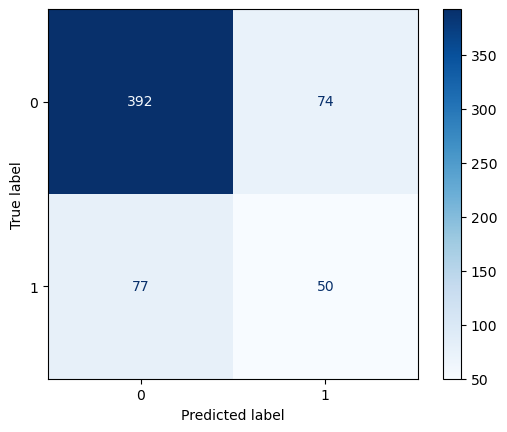

In [274]:
#Check setelah crosvalidation
y_pred_test_dt = dt.predict(feature_test1)

print('F1 Score - Test Set   : ', f1_score(y_test, y_pred_test_dt), '\n')
print('ROC-AUC Train: ', roc_auc_score(y_train, y_pred_train_dt), '\n')
print('ROC-AUC Test : ', roc_auc_score(y_test, y_pred_test_dt), '\n')
print('Classification Report Test-set DecissionTree : \n', classification_report(y_test, y_pred_test_dt), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(dt, feature_test1, y_test, cmap='Blues'))

### Random Forest

In [199]:
#melatih model random forest
random.fit(feature_train1, y_train)

RandomForestClassifier()

In [200]:
# melakukan prediksi
y_pred_train_random = random.predict(feature_train1)
y_pred_test_random = random.predict(feature_test1)

Evaluation Random Forest
Training score: 0.9937
Test score: 0.7993 

Classification Report Train-set Random Forest :
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1863
           1       1.00      0.97      0.99       508

    accuracy                           0.99      2371
   macro avg       1.00      0.99      0.99      2371
weighted avg       0.99      0.99      0.99      2371
 

Confusion Matrix      : 


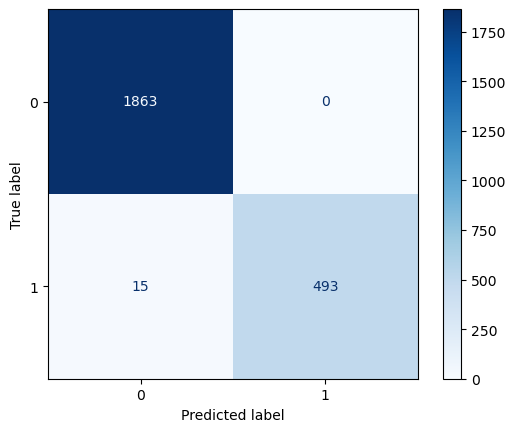

In [257]:
# Menampilkan akurasi prediksi
print("Evaluation Random Forest")
print('Training score: {:.4f}'.format(random.score(feature_train1, y_train)))
print('Test score: {:.4f}'.format(random.score(feature_test1, y_test)), '\n')
# Menampilkan classification report untuk data Train
print('Classification Report Train-set Random Forest :')
print(classification_report(y_train,y_pred_train_random), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(random, feature_train1, y_train, cmap='Blues'))

#### Crosvalidation

In [202]:
# Cross validation
f1_cv_random = cross_val_score(random, 
                                           feature_train1, 
                                           y_train, 
                                           cv=5, 
                                           scoring='f1')

print('F1 Score - All - Cross Validation  : ', f1_cv_random)
print('F1 Score - Mean - Cross Validation : ', f1_cv_random.mean())
print('F1 Score - Std - Cross Validation  : ', f1_cv_random.std())
print('F1 Score - Range of Test-Set       : ', (f1_cv_random.mean()-f1_cv_random.std()) , '-', (f1_cv_random.mean()+f1_cv_random.std()))

F1 Score - All - Cross Validation  :  [0.56       0.44848485 0.53254438 0.5625     0.55      ]
F1 Score - Mean - Cross Validation :  0.5307058454366146
F1 Score - Std - Cross Validation  :  0.04243807889289085
F1 Score - Range of Test-Set       :  0.4882677665437237 - 0.5731439243295054


F1 Score - Test Set   :  0.41379310344827597 

ROC-AUC Train :  0.985236220472441 

ROC-AUC Test :  0.6288736440133824 

Classification Report Test-set Random Forest : 
               precision    recall  f1-score   support

           0       0.84      0.93      0.88       466
           1       0.55      0.33      0.41       127

    accuracy                           0.80       593
   macro avg       0.69      0.63      0.65       593
weighted avg       0.77      0.80      0.78       593
 

Confusion Matrix      : 


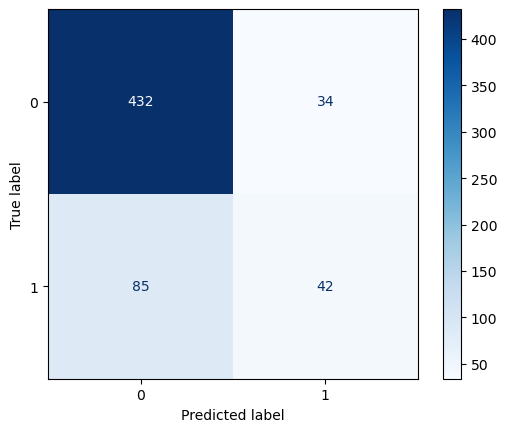

In [275]:
#Check setelah crosvalidation
y_pred_test_random = random.predict(feature_test1)

print('F1 Score - Test Set   : ', f1_score(y_test, y_pred_test_random), '\n')
print('ROC-AUC Train : ', roc_auc_score(y_train, y_pred_train_random), '\n')
print('ROC-AUC Test : ', roc_auc_score(y_test, y_pred_test_random), '\n')
print('Classification Report Test-set Random Forest : \n', classification_report(y_test, y_pred_test_random), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(random, feature_test1, y_test, cmap='Blues'))

### KNN

In [204]:
#melatih model knn
knn.fit(feature_train1, y_train)

KNeighborsClassifier()

In [205]:
# melakukan prediksi
y_pred_train_knn = knn.predict(feature_train1)
y_pred_test_knn = knn.predict(feature_test1)

Evaluation KNN
Training score: 0.8591
Test score: 0.7774 

Classification Report Train-set KNN :
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1863
           1       0.73      0.54      0.62       508

    accuracy                           0.86      2371
   macro avg       0.81      0.74      0.77      2371
weighted avg       0.85      0.86      0.85      2371
 

Confusion Matrix      : 


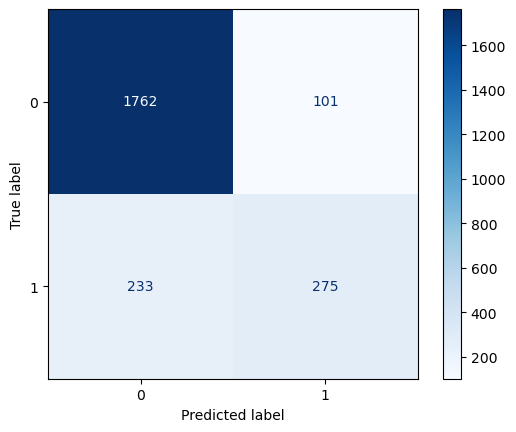

In [259]:
# Menampilkan akurasi prediksi
print("Evaluation KNN")
print('Training score: {:.4f}'.format(knn.score(feature_train1, y_train)))
print('Test score: {:.4f}'.format(knn.score(feature_test1, y_test)), '\n')
# Menampilkan classification report untuk data Train
print('Classification Report Train-set KNN :')
print(classification_report(y_train,y_pred_train_knn), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(knn, feature_train1, y_train, cmap='Blues'))

#### Crosvalidation

In [208]:
# Cross validation
f1_cv_knn = cross_val_score(knn, 
                                           feature_train1, 
                                           y_train, 
                                           cv=5, 
                                           scoring='f1')

print('F1 Score - All - Cross Validation  : ', f1_cv_knn)
print('F1 Score - Mean - Cross Validation : ', f1_cv_knn.mean())
print('F1 Score - Std - Cross Validation  : ', f1_cv_knn.std())
print('F1 Score - Range of Test-Set       : ', (f1_cv_knn.mean()-f1_cv_knn.std()) , '-', (f1_cv_knn.mean()+f1_cv_knn.std()))

F1 Score - All - Cross Validation  :  [0.57591623 0.53409091 0.52941176 0.54545455 0.50292398]
F1 Score - Mean - Cross Validation :  0.5375594852452033
F1 Score - Std - Cross Validation  :  0.023713315673176073
F1 Score - Range of Test-Set       :  0.5138461695720272 - 0.5612728009183793


F1 Score - Test Set   :  0.42105263157894735 

ROC-AUC Train:  0.7435624743766932 

ROC-AUC Test :  0.6321094251630563 

Classification Report Test-set KNN : 
               precision    recall  f1-score   support

           0       0.84      0.89      0.86       466
           1       0.48      0.38      0.42       127

    accuracy                           0.78       593
   macro avg       0.66      0.63      0.64       593
weighted avg       0.76      0.78      0.77       593
 

Confusion Matrix      : 


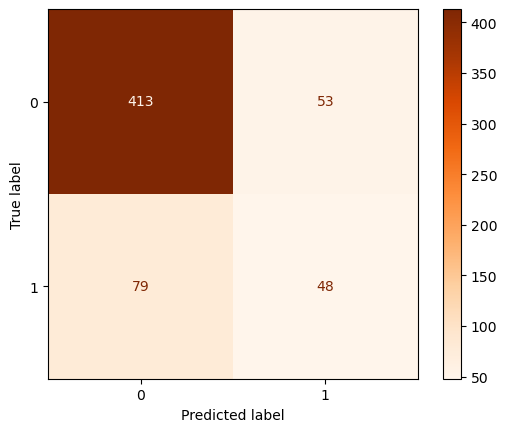

In [277]:
#Check setelah crosvalidation
y_pred_test_knn = knn.predict(feature_test1)

print('F1 Score - Test Set   : ', f1_score(y_test, y_pred_test_knn), '\n')
print('ROC-AUC Train: ', roc_auc_score(y_train, y_pred_train_knn), '\n')
print('ROC-AUC Test : ', roc_auc_score(y_test, y_pred_test_knn), '\n')
print('Classification Report Test-set KNN : \n', classification_report(y_test, y_pred_test_knn), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(knn, feature_test1, y_test, cmap='Oranges'))

### NB

In [210]:
nb.fit(feature_train1, y_train)

GaussianNB()

In [211]:
# melakukan prediksi
y_pred_train_nb = nb.predict(feature_train1)
y_pred_test_nb =nb.predict(feature_test1)

Evaluation nb
Training score: 0.7609
Test score: 0.7167 

Classification Report Train-set nb :
              precision    recall  f1-score   support

           0       0.89      0.79      0.84      1863
           1       0.46      0.66      0.54       508

    accuracy                           0.76      2371
   macro avg       0.68      0.72      0.69      2371
weighted avg       0.80      0.76      0.77      2371
 

Confusion Matrix      : 


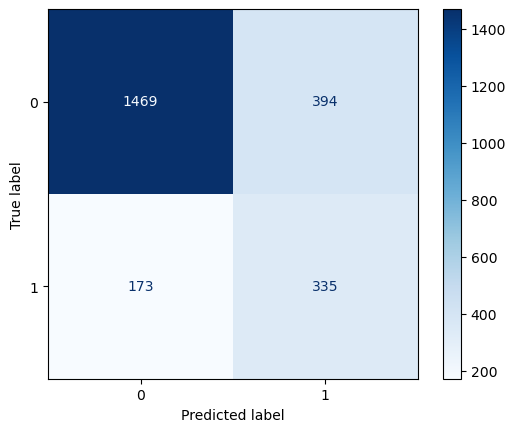

In [248]:
# Menampilkan akurasi prediksi
print("Evaluation nb")
print('Training score: {:.4f}'.format(nb.score(feature_train1, y_train)))
print('Test score: {:.4f}'.format(nb.score(feature_test1, y_test)), '\n')
# Menampilkan classification report untuk data Train
print('Classification Report Train-set nb :')
print(classification_report(y_train,y_pred_train_nb), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(nb, feature_train1, y_train, cmap='Blues'))

#### Crosvalidation

In [213]:
# Cross validation
f1_cv_nb = cross_val_score(nb, 
                                           feature_train1, 
                                           y_train, 
                                           cv=5, 
                                           scoring='f1')

print('F1 Score - All - Cross Validation  : ', f1_cv_nb)
print('F1 Score - Mean - Cross Validation : ', f1_cv_nb.mean())
print('F1 Score - Std - Cross Validation  : ', f1_cv_nb.std())
print('F1 Score - Range of Test-Set       : ', (f1_cv_nb.mean()-f1_cv_nb.std()) , '-', (f1_cv_nb.mean()+f1_cv_nb.std()))

F1 Score - All - Cross Validation  :  [0.525      0.49152542 0.60079051 0.54545455 0.53941909]
F1 Score - Mean - Cross Validation :  0.5404379140308561
F1 Score - Std - Cross Validation  :  0.035494793418894374
F1 Score - Range of Test-Set       :  0.5049431206119617 - 0.5759327074497504


F1 Score - Test Set   :  0.46153846153846156 

ROC-AUC Train :  0.7239809848648145 

ROC-AUC Test :  0.6622199317360007 

Classification Report Test-set Logistic Regression : 
               precision    recall  f1-score   support

           0       0.87      0.76      0.81       466
           1       0.39      0.57      0.46       127

    accuracy                           0.72       593
   macro avg       0.63      0.66      0.63       593
weighted avg       0.76      0.72      0.73       593
 

Confusion Matrix      : 


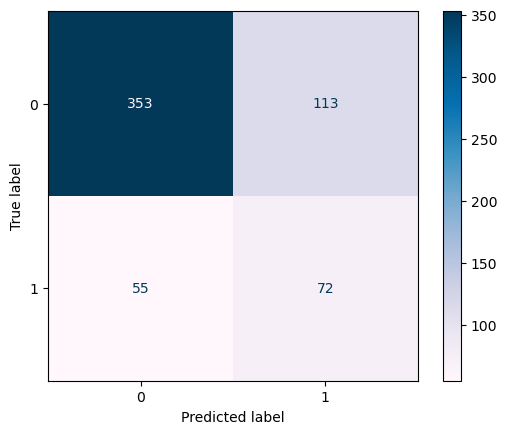

In [279]:
#Check setelah crosvalidation
y_pred_test_nb = nb.predict(feature_test1)

print('F1 Score - Test Set   : ', f1_score(y_test, y_pred_test_nb), '\n')
print('ROC-AUC Train : ', roc_auc_score(y_train, y_pred_train_nb), '\n')
print('ROC-AUC Test : ', roc_auc_score(y_test, y_pred_test_nb), '\n')
print('Classification Report Test-set Logistic Regression : \n', classification_report(y_test, y_pred_test_nb), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(nb, feature_test1, y_test, cmap='PuBu'))

### AdaBoost

In [217]:
# melatuh model adaboost
adaboost.fit(feature_train1, y_train)

AdaBoostClassifier()

In [218]:
# melakukan prediksi
y_pred_train_adaboost = adaboost.predict(feature_train1)
y_pred_test_adaboost =adaboost.predict(feature_test1)

Evaluation Logistic Regression
Training score: 0.8507
Test score: 0.8044 

Classification Report Train-set Logistic Regression :
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1863
           1       0.77      0.43      0.55       508

    accuracy                           0.85      2371
   macro avg       0.82      0.70      0.73      2371
weighted avg       0.84      0.85      0.83      2371
 

Confusion Matrix      : 


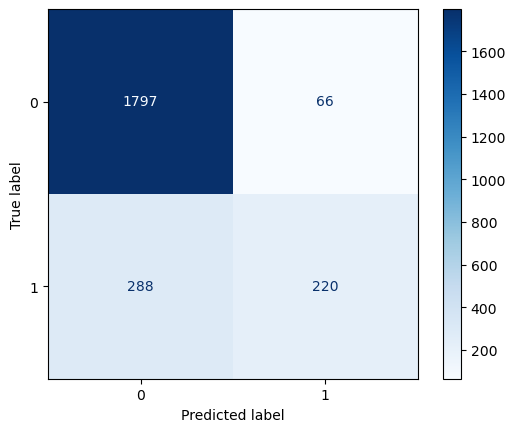

In [219]:
# Menampilkan akurasi prediksi
print("Evaluation Adaboost")
print('Training score: {:.4f}'.format(adaboost.score(feature_train1, y_train)))
print('Test score: {:.4f}'.format(adaboost.score(feature_test1, y_test)), '\n')
# Menampilkan classification report untuk data Train
print('Classification Report Train-set Adaboost :')
print(classification_report(y_train,y_pred_train_adaboost), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(adaboost, feature_train1, y_train, cmap='Blues'))

#### Crossvalidation

In [220]:
# Cross validation
f1_cv_adaboost = cross_val_score(adaboost, 
                                           feature_train1, 
                                           y_train, 
                                           cv=5, 
                                           scoring='f1')

print('F1 Score - All - Cross Validation  : ', f1_cv_adaboost)
print('F1 Score - Mean - Cross Validation : ', f1_cv_adaboost.mean())
print('F1 Score - Std - Cross Validation  : ', f1_cv_adaboost.std())
print('F1 Score - Range of Test-Set       : ', (f1_cv_adaboost.mean()-f1_cv_adaboost.std()) , '-', (f1_cv_adaboost.mean()+f1_cv_adaboost.std()))

F1 Score - All - Cross Validation  :  [0.5308642  0.47368421 0.48684211 0.53164557 0.49681529]
F1 Score - Mean - Cross Validation :  0.503970273912959
F1 Score - Std - Cross Validation  :  0.023456422403725374
F1 Score - Range of Test-Set       :  0.48051385150923365 - 0.5274266963166844


F1 Score - Test Set   :  0.4257425742574258 

ROC-AUC Train:  0.6988220675314137 

ROC-AUC Test:  0.6349565746341793 

Classification Report Test-set Adaboost : 
               precision    recall  f1-score   support

           0       0.84      0.93      0.88       466
           1       0.57      0.34      0.43       127

    accuracy                           0.80       593
   macro avg       0.71      0.63      0.65       593
weighted avg       0.78      0.80      0.78       593
 

Confusion Matrix      : 


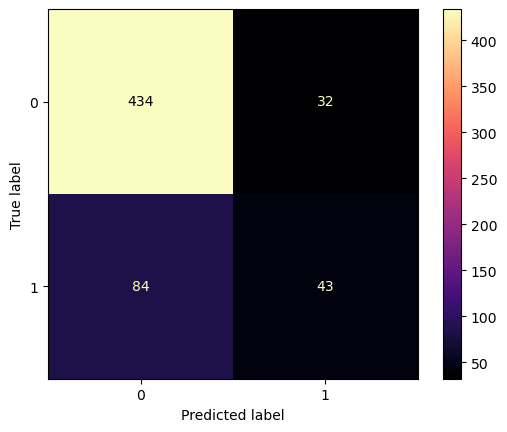

In [281]:
#Check setelah crosvalidation
y_pred_test_adaboost = adaboost.predict(feature_test1)

print('F1 Score - Test Set   : ', f1_score(y_test, y_pred_test_adaboost), '\n')
print('ROC-AUC Train: ', roc_auc_score(y_train, y_pred_train_adaboost), '\n')
print('ROC-AUC Test: ', roc_auc_score(y_test, y_pred_test_adaboost), '\n')
print('Classification Report Test-set Adaboost : \n', classification_report(y_test, y_pred_test_adaboost), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(adaboost, feature_test1, y_test, cmap='magma'))

# 9. Model Evaluation

In [225]:
print('Evaluation Logistic Regression : ')
print('F1 Score Train : ', f1_score(y_train, y_pred_train_logreg))
print('F1 Score Test :', f1_score(y_test, y_pred_test_logreg))
print('Cross-Val mean :', f1_cv_log.mean())
print('Cross-Val std :', f1_cv_log.std())
print('')
print('Evaluation Support Machine Vector (SVC) : ')
print('F1 Score Train : ', f1_score(y_train, y_pred_train_svm))
print('F1 Score Test :', f1_score(y_test, y_pred_test_svm))
print('Cross-Val mean :', f1_cv_svm.mean())
print('Cross-Val std :', f1_cv_svm.std())
print('')
print('Evaluation Decision Tree : ')
print('F1 Score Train : ', f1_score(y_train, y_pred_train_dt))
print('F1 Score Test :', f1_score(y_test, y_pred_test_dt))
print('Cross-Val mean :', f1_cv_dt.mean())
print('Cross-Val std :', f1_cv_dt.std())
print('')
print('Evaluation Random Forest : ')
print('F1 Score Train : ', f1_score(y_train, y_pred_train_random))
print('F1 Score Test :', f1_score(y_test, y_pred_test_random))
print('Cross-Val mean :', f1_cv_random.mean())
print('Cross-Val std :', f1_cv_random.std())
print('')
print('Evaluation KNN : ')
print('F1 Score Train : ', f1_score(y_train, y_pred_train_knn))
print('F1 Score Test :', f1_score(y_test, y_pred_test_knn))
print('Cross-Val mean :', f1_cv_knn.mean())
print('Cross-Val std :', f1_cv_knn.std())
print('')
print('Evaluation Naive Bayes : ')
print('F1 Score Train : ', f1_score(y_train, y_pred_train_nb))
print('F1 Score Test :', f1_score(y_test, y_pred_test_nb))
print('Cross-Val mean :', f1_cv_nb.mean())
print('Cross-Val std :', f1_cv_nb.std())
print('')
print('Evaluation AdaBoost : ')
print('F1 Score Train : ', f1_score(y_train, y_pred_train_adaboost))
print('F1 Score Test :', f1_score(y_test, y_pred_test_adaboost))
print('Cross-Val mean :', f1_cv_adaboost.mean())
print('Cross-Val std :', f1_cv_adaboost.std())
print('')

Evaluation Logistic Regression : 
F1 Score Train :  0.5372005044136191
F1 Score Test : 0.43434343434343436
Cross-Val mean : 0.5233867801841371
Cross-Val std : 0.05116295889856292

Evaluation Support Machine Vector (SVC) : 
F1 Score Train :  0.573170731707317
F1 Score Test : 0.44878048780487806
Cross-Val mean : 0.5536478858424483
Cross-Val std : 0.03579363780687108

Evaluation Decision Tree : 
F1 Score Train :  0.9850149850149851
F1 Score Test : 0.398406374501992
Cross-Val mean : 0.4050680417731778
Cross-Val std : 0.033851977226094336

Evaluation Random Forest : 
F1 Score Train :  0.9850149850149851
F1 Score Test : 0.41379310344827597
Cross-Val mean : 0.5307058454366146
Cross-Val std : 0.04243807889289085

Evaluation KNN : 
F1 Score Train :  0.6221719457013575
F1 Score Test : 0.42105263157894735
Cross-Val mean : 0.5375594852452033
Cross-Val std : 0.023713315673176073

Evaluation Naive Bayes : 
F1 Score Train :  0.5416329830234438
F1 Score Test : 0.46153846153846156
Cross-Val mean : 0.54

### Hyperparametertuning

disini saya menggunakan RandomSearchCV dalam HyperTuning

In [226]:
# membuat variable untuk parameter
estimator = [DecisionTreeClassifier(), SVC()]
n_estimators = [1, 5, 10, 50, 100, 500]
learning_rate = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
random_grid = {'n_estimators': n_estimators,
               'estimator':estimator,
               'learning_rate':learning_rate,
               'algorithm':['SAMME', 'SAMME.R']
               }
random_grid

{'n_estimators': [1, 5, 10, 50, 100, 500],
 'estimator': [DecisionTreeClassifier(), SVC()],
 'learning_rate': [0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
 'algorithm': ['SAMME', 'SAMME.R']}

In [230]:
# Menggunakan randomsearch
ab_randomcv = RandomizedSearchCV(estimator=AdaBoostClassifier(), 
                                 param_distributions=random_grid,
                                 n_iter=50,
                                 cv=5, 
                                 random_state=46, 
                                 n_jobs=-1, 
                                 scoring='f1')
ab_randomcv.fit(feature_train1, y_train)

c:\Users\maddi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
75 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\maddi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\maddi\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py", line 142, in fit
    self._validate_estimator()
  File "c:\Users\maddi\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py", line 517, in _validate_estimator
    raise TypeError(
TypeError: AdaBoostClassifi

RandomizedSearchCV(cv=5, estimator=AdaBoostClassifier(), n_iter=50, n_jobs=-1,
                   param_distributions={'algorithm': ['SAMME', 'SAMME.R'],
                                        'estimator': [DecisionTreeClassifier(),
                                                      SVC()],
                                        'learning_rate': [0.0, 0.2, 0.4, 0.6,
                                                          0.8, 1.0],
                                        'n_estimators': [1, 5, 10, 50, 100,
                                                         500]},
                   random_state=46, scoring='f1')

In [233]:
# Menampilkan best estimator
print(ab_randomcv.best_estimator_)
print(ab_randomcv.best_params_)
print(ab_randomcv.best_index_)

AdaBoostClassifier(algorithm='SAMME', estimator=DecisionTreeClassifier(),
                   learning_rate=0.2, n_estimators=500)
{'n_estimators': 500, 'learning_rate': 0.2, 'estimator': DecisionTreeClassifier(), 'algorithm': 'SAMME'}
0


In [234]:
#Membuat variabel untuk best estimator
best_estimator = ab_randomcv.best_estimator_

In [282]:
#melakukan prediksi menggunakan model yang sudah di tuning
y_pred_test_hyp=best_estimator.predict(feature_test1)
y_pred_train_hyp=best_estimator.predict(feature_train1)

F1 Score - Test Set   :  0.3786008230452675 

Classification Report : 
               precision    recall  f1-score   support

           0       0.83      0.85      0.84       466
           1       0.40      0.36      0.38       127

    accuracy                           0.75       593
   macro avg       0.61      0.61      0.61       593
weighted avg       0.74      0.75      0.74       593
 

ROC-AUC Train :  0.985236220472441 

ROC-AUC Test:  0.6059950660673853 

Confusion Matrix      : 


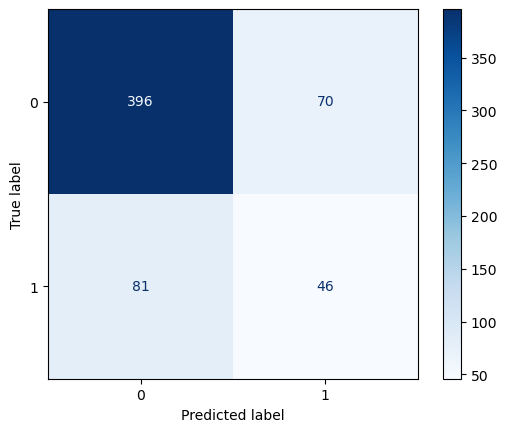

In [284]:
# Classofication Report


print('F1 Score - Test Set   : ', f1_score(y_test, y_pred_test_hyp), '\n')
print('Classification Report : \n', classification_report(y_test, y_pred_test_hyp), '\n')
print('ROC-AUC Train : ', roc_auc_score(y_train, y_pred_train_hyp), '\n')
print('ROC-AUC Test: ', roc_auc_score(y_test, y_pred_test_hyp), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(best_estimator, feature_test1, y_test, cmap='Blues'))

In [249]:
# Membuat dataframe yang belum dituning
all_reports = {}
score_reports = {
    'train - precision' : precision_score(y_train, y_pred_train_adaboost),
    'train - recall' : recall_score(y_train, y_pred_train_adaboost),
    'train - accuracy' : accuracy_score(y_train, y_pred_train_adaboost),
    'train - f1_score' : f1_score(y_train, y_pred_train_adaboost),
    'test - precision' : precision_score(y_test, y_pred_test_adaboost),
    'test - recall' : recall_score(y_test, y_pred_test_adaboost),
    'test - accuracy_score' : accuracy_score(y_test, y_pred_test_adaboost),
    'test - f1_score' : f1_score(y_test, y_pred_test_adaboost),
}
all_reports['Sebelum Tuning'] = score_reports
pd.DataFrame(all_reports)


Sebelum Tuning
test - accuracy_score        0.804384
test - f1_score              0.425743
test - precision             0.573333
test - recall                0.338583
train - accuracy             0.850696
train - f1_score             0.554156
train - precision            0.769231
train - recall               0.433071

In [250]:
# Memasukan report Random Search dan membandingan dengan model yang belum dituning
score_reports = {
    'train - precision' : precision_score(y_train, y_pred_train_adaboost),
    'train - recall' : recall_score(y_train, y_pred_train_adaboost),
    'train - accuracy' : accuracy_score(y_train, y_pred_train_adaboost),
    'train - f1_score' : f1_score(y_train, y_pred_train_adaboost),
    'test - precision' : precision_score(y_test, y_pred_test_hyp),
    'test - recall' : recall_score(y_test, y_pred_test_hyp),
    'test - accuracy_score' : accuracy_score(y_test, y_pred_test_hyp),
    'test - f1_score' : f1_score(y_test, y_pred_test_hyp),
}
all_reports['Random Search'] = score_reports
pd.DataFrame(all_reports)


Sebelum Tuning  Random Search
train - precision            0.769231       0.769231
train - recall               0.433071       0.433071
train - accuracy             0.850696       0.850696
train - f1_score             0.554156       0.554156
test - precision             0.573333       0.396552
test - recall                0.338583       0.362205
test - accuracy_score        0.804384       0.745363
test - f1_score              0.425743       0.378601

setelah dilakukan tuning dengan RandomSearchCV hasil terbaik pada `recal` terdapat pada model yang sudah dituning. Dengan mempertimbang kan hasil recall, terdapat kesalahan prediksi yang customer yang harus nya tidak terblokir, malah terblokir. Ini lebih baik ketimbang customer yang tidak bisa membayar kredit malah tetap bisa menggunakan kredit. Jika terdapat banyak customer yang tidak bisa membayar dapat mengakibat kan CashFlow Perusahaan yang tersendat.  

# 10. Model Saving

In [263]:
# Save File

# Modelling
with open('adaboost_model.pkl', 'wb') as file_1:
    pickle.dump(best_estimator, file_1)


# Pre-processing

with open('scaler.pkl', 'wb') as file_2:
    pickle.dump(scaler, file_2)
    
with open ('winsoriser.pkl', 'wb') as file_3:
    pickle.dump(winsoriser,file_3)
    
# List Numeric & Category
with open('num_cols_sc.txt', 'w') as file_4:
    json.dump(num_cols_scaled, file_4)

with open('num_cols_nsc.txt', 'w') as file_5:
    json.dump(num_cols_non_scaled, file_5)
    